In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/boujdour1/Boujdour 10T (1).csv


In [2]:
import pandas as pd
df = pd.read_csv('/kaggle/input/boujdour1/Boujdour 10T (1).csv', sep=";")
df.head()

,DateTime,zone1,zone2,zone3
0,14/09/2022 17:10,"59,81","14,88","60,77"
1,14/09/2022 17:20,"59,68","15,08","60,52"
2,14/09/2022 17:30,"60,45","15,25","60,63"
3,14/09/2022 17:40,"59,72","15,15","59,29"
4,14/09/2022 17:50,"60,75","15,60","60,43"


In [3]:
for col in df.columns[1:]:
  df[col]=df[col].str.replace(",",".",regex=False)


In [4]:
for col in df.columns[1:]:
  df[col]=df[col].astype(float)

In [5]:
# Ensure 'DateTime' is datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'], dayfirst=True, errors='coerce')

# Set DateTime as index
df = df.set_index('DateTime')

# Sort by datetime just in case
df = df.sort_index()

# Now resampling works
data_hourly = df.resample('1h').sum()
data_hourly_mean = df.resample('1h').mean()
data_daily_mean = data_hourly_mean.resample('1D').mean()


In [6]:
!pip install optuna

In [7]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install tensorflow

In [9]:
!pip install prophet lightgbm optuna tensorflow -q


In [10]:
# ================================================================
# 📘 Robust Hybrid Feature Engineering Pipeline
# Prophet (Daily) + LSTM (Hourly) + Symbolic & Programmatic Features
# ================================================================

import numpy as np
import pandas as pd
from datetime import datetime

# ================================================================
# 1️⃣ LOAD AND PREPARE DATA
# ================================================================
# Assume you already have:
#  🔹 data → original 10-min resolution dataframe
#  🔹 data_hourly_mean → hourly mean dataframe (aggregated from data)
# Example: data_hourly_mean = data.resample('H').mean()

df_hourly = data_hourly_mean.copy()
df_hourly.index.name = "DateTime"

print(f"Raw hourly data shape: {df_hourly.shape}")
print(df_hourly.head())

# ================================================================
# 2️⃣ FEATURE ENGINEERING UTILITIES
# ================================================================

def add_time_features(df):
    """Add calendar and cyclical time features."""
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    return df

def add_lag_and_rolling(df, zones, lags=[1,3,6,12,24], rolls=[3,6,12,24]):
    """Add lag and rolling statistical features."""
    df = df.copy()
    for z in zones:
        for l in lags:
            df[f"{z}_lag_{l}"] = df[z].shift(l)
        for w in rolls:
            df[f"{z}_roll_mean_{w}"] = df[z].rolling(window=w, min_periods=1).mean()
            df[f"{z}_roll_std_{w}"] = df[z].rolling(window=w, min_periods=1).std().fillna(0)
    return df

def add_derivatives(df, zones):
    """Add first/second derivatives and percentage change."""
    df = df.copy()
    for z in zones:
        df[f"{z}_diff_1"] = df[z].diff(1)
        df[f"{z}_diff_2"] = df[z].diff(2)
        df[f"{z}_pct_change_1"] = df[z].pct_change(1).replace([np.inf,-np.inf], np.nan).fillna(0)
    return df

def add_fourier_terms(df, period_hours=24, K=3):
    """Add Fourier seasonal terms."""
    df = df.copy()
    t = np.arange(len(df))
    for k in range(1, K+1):
        df[f"fourier_sin_{k}"] = np.sin(2*np.pi*k*t/period_hours)
        df[f"fourier_cos_{k}"] = np.cos(2*np.pi*k*t/period_hours)
    return df

def add_symbolic_like_features(df, zones):
    """Add interpretable symbolic-like nonlinear feature combinations."""
    df = df.copy()
    for z in zones:
        df[f"{z}_sym_sinlag3_logroll6"] = np.sin(df[f"{z}_lag_3"].fillna(0)) * np.log1p(df[f"{z}_roll_mean_6"].fillna(0))
        df[f"{z}_sym_lag1_over_lag24"] = df[f"{z}_lag_1"] / (df[f"{z}_lag_24"].replace(0, np.nan))
        df[f"{z}_sym_prod_diff1_diff2"] = df[f"{z}_diff_1"].fillna(0) * df[f"{z}_diff_2"].fillna(0)
    return df

# ================================================================
# 3️⃣ APPLY PROGRAMMATIC + SYMBOLIC FEATURE ENGINEERING
# ================================================================
zones = [c for c in df_hourly.columns if c.startswith("zone")]
df = df_hourly.copy()
df = add_time_features(df)
df = add_lag_and_rolling(df, zones)
df = add_derivatives(df, zones)
df = add_fourier_terms(df, period_hours=24, K=2)
df = add_symbolic_like_features(df, zones)

print(f"✅ After feature engineering: {df.shape[1]} columns")

# ================================================================
# 4️⃣ PROPHET-DERIVED DAILY FEATURES (TREND + WEEKLY + YEARLY)
# ================================================================
try:
    from prophet import Prophet
    prophet_available = True
except:
    try:
        from fbprophet import Prophet
        prophet_available = True
    except:
        prophet_available = False

if prophet_available:
    print("🧭 Prophet detected — extracting daily components...")
    daily = df_hourly.sum(axis=1).resample("D").mean().reset_index()
    daily.columns = ["ds", "y"]

    m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(daily)
    forecast = m.predict(m.make_future_dataframe(periods=0, freq="D"))
    comp = forecast[["ds", "trend", "weekly", "yearly", "yhat"]].set_index("ds")
    comp["residual"] = daily.set_index("ds")["y"] - comp["yhat"]

    # Upsample to hourly and align with df
    comp_hourly = comp.reindex(pd.date_range(comp.index.min(), comp.index.max(), freq="H")).ffill()
    comp_hourly = comp_hourly.reindex(df.index, method="ffill")
    for col in comp_hourly.columns:
        df[f"prophet_{col}"] = comp_hourly[col].values
else:
    print("⚙️ Prophet not available — using STL decomposition fallback.")
    from statsmodels.tsa.seasonal import STL
    daily = df_hourly.sum(axis=1).resample("D").mean()
    stl = STL(daily.interpolate(), period=7)
    res = stl.fit()
    comp = pd.DataFrame({
        "trend": res.trend,
        "seasonal": res.seasonal,
        "resid": res.resid
    })
    comp_hourly = comp.reindex(pd.date_range(comp.index.min(), comp.index.max(), freq="H")).ffill()
    comp_hourly = comp_hourly.reindex(df.index, method="ffill")
    df["prophet_trend"] = comp_hourly["trend"].values
    df["prophet_weekly"] = comp_hourly["seasonal"].values
    df["prophet_residual"] = comp_hourly["resid"].values

# ================================================================
# 5️⃣ LSTM-DERIVED TEMPORAL EMBEDDINGS (OPTIONAL)
# ================================================================
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import LSTM, Dense, Input
    from tensorflow.keras.callbacks import EarlyStopping
    tf_available = True
except:
    tf_available = False

if tf_available:
    print("🔶 TensorFlow available — training LSTM encoder...")
    feature_cols = [c for c in df.columns if not c.startswith("zone")] + [f"{z}_lag_1" for z in zones]
    feature_cols = [c for c in feature_cols if c in df.columns]
    df_train = df[feature_cols].fillna(method="ffill").fillna(0)
    seq_len = 24  # one-day lookback window

    X, y = [], []
    total = df_hourly.sum(axis=1)
    for i in range(len(df_train)-seq_len):
        X.append(df_train.iloc[i:i+seq_len].values)
        y.append(total.iloc[i+seq_len])
    X, y = np.array(X), np.array(y)

    if len(X) > 0:
        inp = Input(shape=(X.shape[1], X.shape[2]))
        lstm_layer = LSTM(32, return_sequences=False, name="encoder_lstm")(inp)
        out = Dense(1, activation="linear")(lstm_layer)
        model = Model(inputs=inp, outputs=out)
        model.compile(optimizer="adam", loss="mse")
        es = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
        model.fit(X, y, epochs=30, batch_size=32, callbacks=[es], verbose=0)

        encoder = Model(inputs=inp, outputs=model.get_layer("encoder_lstm").output)
        embeddings = encoder.predict(X, verbose=0)
        emb_df = pd.DataFrame(embeddings, index=df.index[seq_len:seq_len+len(embeddings)])
        for i_col in range(emb_df.shape[1]):
            df[f"lstm_emb_{i_col}"] = np.nan
            df.loc[emb_df.index, f"lstm_emb_{i_col}"] = emb_df.iloc[:, i_col].values
    else:
        print("Not enough samples for LSTM embedding.")
else:
    print("❌ TensorFlow not available — skipping LSTM embedding features.")

# ================================================================
# 6️⃣ SAVE & DISPLAY FINAL FEATURE DATASET
# ================================================================
print(f"\n✅ Final engineered DataFrame shape: {df.shape}")
print(f"✅ Total columns: {len(df.columns)}")
print(df.head())

df.to_csv("final_engineered_df.csv")
print("💾 Saved as final_engineered_df.csv")


Raw hourly data shape: (14816, 3)
                         zone1      zone2      zone3
DateTime                                            
2022-09-14 17:00:00  60.082000  15.192000  60.328000
2022-09-14 18:00:00  64.758333  16.280000  58.718333
2022-09-14 19:00:00  66.251667  17.761667  54.316667
2022-09-14 20:00:00  79.946667  24.691667  64.728333
2022-09-14 21:00:00  86.553333  25.910000  70.788333


/tmp/ipykernel_55/2474188632.py:56: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f"{z}_pct_change_1"] = df[z].pct_change(1).replace([np.inf,-np.inf], np.nan).fillna(0)
/tmp/ipykernel_55/2474188632.py:56: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f"{z}_pct_change_1"] = df[z].pct_change(1).replace([np.inf,-np.inf], np.nan).fillna(0)
/tmp/ipykernel_55/2474188632.py:56: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to

✅ After feature engineering: 70 columns
🧭 Prophet detected — extracting daily components...


08:14:32 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_55/2474188632.py:115: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  comp_hourly = comp.reindex(pd.date_range(comp.index.min(), comp.index.max(), freq="H")).ffill()
/tmp/ipykernel_55/2474188632.py:152: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train = df[feature_cols].fillna(method="ffill").fillna(0)


🔶 TensorFlow available — training LSTM encoder...


I0000 00:00:1768637675.405376      93 cuda_dnn.cc:529] Loaded cuDNN version 91002



✅ Final engineered DataFrame shape: (14816, 107)
✅ Total columns: 107
                         zone1      zone2      zone3  hour  dayofweek  month  \
DateTime                                                                       
2022-09-14 17:00:00  60.082000  15.192000  60.328000    17          2      9   
2022-09-14 18:00:00  64.758333  16.280000  58.718333    18          2      9   
2022-09-14 19:00:00  66.251667  17.761667  54.316667    19          2      9   
2022-09-14 20:00:00  79.946667  24.691667  64.728333    20          2      9   
2022-09-14 21:00:00  86.553333  25.910000  70.788333    21          2      9   

                     is_weekend  hour_sin      hour_cos  zone1_lag_1  ...  \
DateTime                                                              ...   
2022-09-14 17:00:00           0 -0.965926 -2.588190e-01          NaN  ...   
2022-09-14 18:00:00           0 -1.000000 -1.836970e-16    60.082000  ...   
2022-09-14 19:00:00           0 -0.965926  2.588190e-01    6

STACKING HYBRID MODEL WITH ALL MANDATORY CORRECTIONS
📁 Loading data...


2026-01-16 18:00:24,559 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/ubt1i0px.json
2026-01-16 18:00:24,562 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/9sltzdt7.json
2026-01-16 18:00:24,563 [DEBUG] idx 0
2026-01-16 18:00:24,564 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:00:24,564 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78315', 'data', 'file=/tmp/tmp2dg0jbas/ubt1i0px.json', 'init=/tmp/tmp2dg0jbas/9sltzdt7.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model3eauhp3i/prophet_model-20260116180024.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:00:24 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:00:24,565 [INFO] Chain [1] start processing


✅ Loaded DataFrame shape: (14816, 107)
🔍 Cleaning data...
✅ Data cleaned. Remaining NaN: 0
🎯 Found zones: ['zone1', 'zone2', 'zone3']

🚀 Starting model training...
ROBUST STACKING HYBRID MODEL WITH ALL MANDATORY CORRECTIONS
Processing 3 zones: ['zone1', 'zone2', 'zone3']

ZONE: zone1
  Generated 17 walk-forward folds

    Fold 1: Train up to index 2160, Test 2160 to 2880
      Train samples: 2160, Test samples: 720


18:00:24 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:00:24,903 [INFO] Chain [1] done processing
2026-01-16 18:00:33,273 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/17xg12yg.json
2026-01-16 18:00:33,276 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/vbiiz3zp.json
2026-01-16 18:00:33,278 [DEBUG] idx 0
2026-01-16 18:00:33,279 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:00:33,280 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85925', 'data', 'file=/tmp/tmp2dg0jbas/17xg12yg.json', 'init=/tmp/tmp2dg0jbas/vbiiz3zp.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model0oykpcer/prophet_model-20260116180033.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:00:33 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:00:33,280 [INFO] Chain [1] start processing


      Ablation Study (Fold 1):
        prophet_only: R²=-25.863, RMSE=87.538
        lstm_only: R²=0.775, RMSE=8.019


18:00:33 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:00:33,630 [INFO] Chain [1] done processing


      LSTM Train RMSE: 21.626, Test RMSE: 26.206, Gap: -4.580


2026-01-16 18:00:47,264 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:00:47,266 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/s33ib3pl.json
2026-01-16 18:00:47,267 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/vrigymww.json
2026-01-16 18:00:47,269 [DEBUG] idx 0
2026-01-16 18:00:47,269 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:00:47,270 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=107', 'data', 'file=/tmp/tmp2dg0jbas/s33ib3pl.json', 'init=/tmp/tmp2dg0jbas/vrigymww.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelc1b9x9m_/prophet_model-20260116180047.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:00:47 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:00:47,270 [INFO] Chain [1] start processing
18:00:47 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:00:47,322 [INFO] Chain [1] done processing
2026-01-16 18:00:47,768 [DEBUG] input t

      Stacking R²: -0.944, RMSE: 23.549

    Fold 2: Train up to index 2880, Test 2880 to 3600
      Train samples: 2880, Test samples: 720
      LSTM Train RMSE: 23.280, Test RMSE: 22.521, Gap: 0.759


2026-01-16 18:01:00,755 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:01:00,758 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/7qy87t3c.json
2026-01-16 18:01:00,759 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/fd75neh3.json
2026-01-16 18:01:00,760 [DEBUG] idx 0
2026-01-16 18:01:00,761 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:01:00,762 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3239', 'data', 'file=/tmp/tmp2dg0jbas/7qy87t3c.json', 'init=/tmp/tmp2dg0jbas/fd75neh3.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model0p93b30s/prophet_model-20260116180100.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:01:00 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:01:00,762 [INFO] Chain [1] start processing
18:01:00 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:01:00,830 [INFO] Chain [1] done processing
2026-01-16 18:01:01,365 [DEBUG] input 

      Stacking R²: -0.821, RMSE: 28.847

    Fold 3: Train up to index 3600, Test 3600 to 4320
      Train samples: 3600, Test samples: 720
      LSTM Train RMSE: 9.141, Test RMSE: 8.265, Gap: 0.876


2026-01-16 18:01:24,486 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:01:24,489 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/wsj4ftat.json
2026-01-16 18:01:24,490 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/w9k8d44b.json
2026-01-16 18:01:24,491 [DEBUG] idx 0
2026-01-16 18:01:24,492 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:01:24,492 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37020', 'data', 'file=/tmp/tmp2dg0jbas/wsj4ftat.json', 'init=/tmp/tmp2dg0jbas/w9k8d44b.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelnrz1f7g_/prophet_model-20260116180124.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:01:24 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:01:24,493 [INFO] Chain [1] start processing
18:01:24 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:01:24,546 [INFO] Chain [1] done processing
2026-01-16 18:01:25,203 [DEBUG] input

      Stacking R²: 0.790, RMSE: 8.354

    Fold 4: Train up to index 4320, Test 4320 to 5040
      Train samples: 4320, Test samples: 720
      LSTM Train RMSE: 9.016, Test RMSE: 7.841, Gap: 1.176


2026-01-16 18:01:58,716 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:01:58,718 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/86ovfmmp.json
2026-01-16 18:01:58,720 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/ja3rarhc.json
2026-01-16 18:01:58,721 [DEBUG] idx 0
2026-01-16 18:01:58,721 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:01:58,722 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8722', 'data', 'file=/tmp/tmp2dg0jbas/86ovfmmp.json', 'init=/tmp/tmp2dg0jbas/ja3rarhc.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelploxjwox/prophet_model-20260116180158.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:01:58,722 [INFO] Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:01:58,775 [INFO] Chain [1] done processing
2026-01-16 18:01:59,620 [DEBUG] input 

      Stacking R²: 0.784, RMSE: 7.702

    Fold 5: Train up to index 5040, Test 5040 to 5760
      Train samples: 5040, Test samples: 720
      LSTM Train RMSE: 21.558, Test RMSE: 18.385, Gap: 3.172


2026-01-16 18:02:16,418 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:02:16,421 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/8p5y1mv1.json
2026-01-16 18:02:16,422 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/exh3ln62.json
2026-01-16 18:02:16,423 [DEBUG] idx 0
2026-01-16 18:02:16,423 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:02:16,424 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79269', 'data', 'file=/tmp/tmp2dg0jbas/8p5y1mv1.json', 'init=/tmp/tmp2dg0jbas/exh3ln62.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model_omnmijb/prophet_model-20260116180216.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:02:16 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:02:16,424 [INFO] Chain [1] start processing
18:02:16 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:02:16,476 [INFO] Chain [1] done processing
2026-01-16 18:02:17,438 [DEBUG] input

      Stacking R²: -0.269, RMSE: 20.693

    Fold 6: Train up to index 5760, Test 5760 to 6480
      Train samples: 5760, Test samples: 720
      LSTM Train RMSE: 7.979, Test RMSE: 7.744, Gap: 0.234


2026-01-16 18:02:59,711 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:02:59,714 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/ha1nu98h.json
2026-01-16 18:02:59,715 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/kfgkw4be.json
2026-01-16 18:02:59,716 [DEBUG] idx 0
2026-01-16 18:02:59,717 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:02:59,717 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22990', 'data', 'file=/tmp/tmp2dg0jbas/ha1nu98h.json', 'init=/tmp/tmp2dg0jbas/kfgkw4be.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelu4_xmmt_/prophet_model-20260116180259.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:02:59 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:02:59,718 [INFO] Chain [1] start processing
18:02:59 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:02:59,769 [INFO] Chain [1] done processing
2026-01-16 18:03:00,847 [DEBUG] input

      Stacking R²: 0.797, RMSE: 7.926

    Fold 7: Train up to index 6480, Test 6480 to 7200
      Train samples: 6480, Test samples: 720
      LSTM Train RMSE: 10.558, Test RMSE: 8.370, Gap: 2.188


2026-01-16 18:03:32,649 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:03:32,652 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/9gcxe__j.json
2026-01-16 18:03:32,653 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/agvs0suw.json
2026-01-16 18:03:32,655 [DEBUG] idx 0
2026-01-16 18:03:32,656 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:03:32,657 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92901', 'data', 'file=/tmp/tmp2dg0jbas/9gcxe__j.json', 'init=/tmp/tmp2dg0jbas/agvs0suw.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelu1jfyu6g/prophet_model-20260116180332.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:03:32 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:03:32,658 [INFO] Chain [1] start processing
18:03:32 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:03:32,717 [INFO] Chain [1] done processing
2026-01-16 18:03:33,924 [DEBUG] input

      Stacking R²: 0.547, RMSE: 9.126

    Fold 8: Train up to index 7200, Test 7200 to 7920
      Train samples: 7200, Test samples: 720
      LSTM Train RMSE: 7.053, Test RMSE: 9.273, Gap: -2.221


2026-01-16 18:04:25,568 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:04:25,571 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/91mxdh4v.json
2026-01-16 18:04:25,572 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/x2y2r9er.json
2026-01-16 18:04:25,573 [DEBUG] idx 0
2026-01-16 18:04:25,573 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:04:25,574 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12256', 'data', 'file=/tmp/tmp2dg0jbas/91mxdh4v.json', 'init=/tmp/tmp2dg0jbas/x2y2r9er.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modely2clj8ty/prophet_model-20260116180425.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:04:25 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:04:25,574 [INFO] Chain [1] start processing
18:04:25 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:04:25,627 [INFO] Chain [1] done processing
2026-01-16 18:04:26,955 [DEBUG] input

      Stacking R²: 0.726, RMSE: 9.579

    Fold 9: Train up to index 7920, Test 7920 to 8640
      Train samples: 7920, Test samples: 720
      LSTM Train RMSE: 8.683, Test RMSE: 8.090, Gap: 0.594


2026-01-16 18:05:08,075 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:05:08,077 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/g75hhpx7.json
2026-01-16 18:05:08,078 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/n7_uf9qq.json
2026-01-16 18:05:08,079 [DEBUG] idx 0
2026-01-16 18:05:08,080 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:05:08,081 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88378', 'data', 'file=/tmp/tmp2dg0jbas/g75hhpx7.json', 'init=/tmp/tmp2dg0jbas/n7_uf9qq.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model_2v2l598/prophet_model-20260116180508.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:05:08 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:05:08,081 [INFO] Chain [1] start processing
18:05:08 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:05:08,134 [INFO] Chain [1] done processing
2026-01-16 18:05:09,584 [DEBUG] input

      Stacking R²: 0.700, RMSE: 8.408

    Fold 10: Train up to index 8640, Test 8640 to 9360
      Train samples: 8640, Test samples: 720
      LSTM Train RMSE: 7.557, Test RMSE: 8.569, Gap: -1.012


2026-01-16 18:06:11,228 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:06:11,231 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/5us9xw77.json
2026-01-16 18:06:11,232 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/sva65zo9.json
2026-01-16 18:06:11,234 [DEBUG] idx 0
2026-01-16 18:06:11,234 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:06:11,235 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85212', 'data', 'file=/tmp/tmp2dg0jbas/5us9xw77.json', 'init=/tmp/tmp2dg0jbas/sva65zo9.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelp_mw4wof/prophet_model-20260116180611.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:06:11 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:06:11,236 [INFO] Chain [1] start processing
18:06:11 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:06:11,289 [INFO] Chain [1] done processing
2026-01-16 18:06:12,858 [DEBUG] input

      Stacking R²: 0.817, RMSE: 8.799

    Fold 11: Train up to index 9360, Test 9360 to 10080
      Train samples: 9360, Test samples: 720
      LSTM Train RMSE: 8.027, Test RMSE: 8.900, Gap: -0.873


2026-01-16 18:07:06,349 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:07:06,352 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/wvw3twu_.json
2026-01-16 18:07:06,353 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/brx3q6kx.json
2026-01-16 18:07:06,354 [DEBUG] idx 0
2026-01-16 18:07:06,354 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:07:06,355 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65469', 'data', 'file=/tmp/tmp2dg0jbas/wvw3twu_.json', 'init=/tmp/tmp2dg0jbas/brx3q6kx.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelzkww99dq/prophet_model-20260116180706.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:07:06 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:07:06,355 [INFO] Chain [1] start processing
18:07:06 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:07:06,407 [INFO] Chain [1] done processing
2026-01-16 18:07:08,098 [DEBUG] input

      Stacking R²: 0.711, RMSE: 9.178

    Fold 12: Train up to index 10080, Test 10080 to 10800
      Train samples: 10080, Test samples: 720
      LSTM Train RMSE: 7.683, Test RMSE: 6.775, Gap: 0.908


2026-01-16 18:08:18,914 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:08:18,916 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/tq8o789k.json
2026-01-16 18:08:18,918 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/j4tkkzg2.json
2026-01-16 18:08:18,919 [DEBUG] idx 0
2026-01-16 18:08:18,919 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:08:18,920 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36370', 'data', 'file=/tmp/tmp2dg0jbas/tq8o789k.json', 'init=/tmp/tmp2dg0jbas/j4tkkzg2.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelqaekfeiz/prophet_model-20260116180818.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:08:18 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:08:18,921 [INFO] Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:08:18,973 [INFO] Chain [1] done processing
2026-01-16 18:08:20,780 [DEBUG] input

      Stacking R²: 0.765, RMSE: 6.895

    Fold 13: Train up to index 10800, Test 10800 to 11520
      Train samples: 10800, Test samples: 720
      LSTM Train RMSE: 8.718, Test RMSE: 7.869, Gap: 0.849


2026-01-16 18:09:36,162 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:09:36,165 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/6o3ogzwm.json
2026-01-16 18:09:36,166 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/ecs7tn7i.json
2026-01-16 18:09:36,167 [DEBUG] idx 0
2026-01-16 18:09:36,168 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:09:36,168 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56307', 'data', 'file=/tmp/tmp2dg0jbas/6o3ogzwm.json', 'init=/tmp/tmp2dg0jbas/ecs7tn7i.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modeled3hp211/prophet_model-20260116180936.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:09:36 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:09:36,169 [INFO] Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:09:36,221 [INFO] Chain [1] done processing
2026-01-16 18:09:38,171 [DEBUG] input

      Stacking R²: 0.883, RMSE: 5.157

    Fold 14: Train up to index 11520, Test 11520 to 12240
      Train samples: 11520, Test samples: 720
      LSTM Train RMSE: 7.650, Test RMSE: 3.570, Gap: 4.080


2026-01-16 18:10:58,630 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:10:58,633 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/ejynhovz.json
2026-01-16 18:10:58,634 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/npsk_fko.json
2026-01-16 18:10:58,636 [DEBUG] idx 0
2026-01-16 18:10:58,636 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:10:58,637 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98650', 'data', 'file=/tmp/tmp2dg0jbas/ejynhovz.json', 'init=/tmp/tmp2dg0jbas/npsk_fko.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model8653tb6o/prophet_model-20260116181058.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:10:58,637 [INFO] Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:10:58,688 [INFO] Chain [1] done processing
2026-01-16 18:11:00,726 [DEBUG] input

      Stacking R²: 0.813, RMSE: 4.071

    Fold 15: Train up to index 12240, Test 12240 to 12960
      Train samples: 12240, Test samples: 720
      LSTM Train RMSE: 9.365, Test RMSE: 4.921, Gap: 4.444


2026-01-16 18:11:56,573 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:11:56,576 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/rel37epf.json
2026-01-16 18:11:56,577 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/hscm7xox.json
2026-01-16 18:11:56,579 [DEBUG] idx 0
2026-01-16 18:11:56,579 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:11:56,580 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96080', 'data', 'file=/tmp/tmp2dg0jbas/rel37epf.json', 'init=/tmp/tmp2dg0jbas/hscm7xox.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelylhb0423/prophet_model-20260116181156.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:11:56 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:11:56,580 [INFO] Chain [1] start processing
18:11:56 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:11:56,633 [INFO] Chain [1] done processing
2026-01-16 18:11:58,780 [DEBUG] input

      Stacking R²: 0.443, RMSE: 6.660

    Fold 16: Train up to index 12960, Test 12960 to 13680
      Train samples: 12960, Test samples: 720
      LSTM Train RMSE: 7.319, Test RMSE: 7.737, Gap: -0.418


2026-01-16 18:13:28,082 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:13:28,086 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/jjx5wqtv.json
2026-01-16 18:13:28,087 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/e7z1t5lg.json
2026-01-16 18:13:28,089 [DEBUG] idx 0
2026-01-16 18:13:28,089 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:13:28,090 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22438', 'data', 'file=/tmp/tmp2dg0jbas/jjx5wqtv.json', 'init=/tmp/tmp2dg0jbas/e7z1t5lg.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model0jyiqr1v/prophet_model-20260116181328.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:13:28 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:13:28,090 [INFO] Chain [1] start processing
18:13:28 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:13:28,154 [INFO] Chain [1] done processing
2026-01-16 18:13:30,505 [DEBUG] input

      Stacking R²: 0.769, RMSE: 7.740

    Fold 17: Train up to index 13680, Test 13680 to 14400
      Train samples: 13680, Test samples: 720
      LSTM Train RMSE: 12.713, Test RMSE: 4.178, Gap: 8.535


2026-01-16 18:14:54,323 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:14:54,326 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/hruoq51n.json
2026-01-16 18:14:54,327 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/5akrw5s_.json
2026-01-16 18:14:54,328 [DEBUG] idx 0
2026-01-16 18:14:54,328 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:14:54,329 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74913', 'data', 'file=/tmp/tmp2dg0jbas/hruoq51n.json', 'init=/tmp/tmp2dg0jbas/5akrw5s_.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modeliwdyepl1/prophet_model-20260116181454.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:14:54 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:14:54,330 [INFO] Chain [1] start processing
18:14:54 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:14:54,387 [INFO] Chain [1] done processing
2026-01-16 18:14:56,872 [DEBUG] input

      Stacking R²: 0.679, RMSE: 5.134

    ------------------------------
    SUMMARY FOR zone1 (Across 17 valid folds):
    ------------------------------
    Prophet:     R² = -3.773 ± 6.011, RMSE = 30.628 ± 16.697
    LSTM:        R² = 0.536 ± 0.571, RMSE = 9.954 ± 6.293
    Stacking:    R² = 0.482 ± 0.577, RMSE = 10.460 ± 6.962, MAE = 8.061
    Naive:       RMSE = 6.971
    Seas. Naive: RMSE = 12.749
    Error gap:   1.101 (positive = overfitting)
    Improvement: -50.0% vs Naive, 18.0% vs Seasonal Naive

ZONE: zone2
  Generated 17 walk-forward folds

    Fold 1: Train up to index 2160, Test 2160 to 2880
      Train samples: 2160, Test samples: 720


18:14:57 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:14:57,219 [INFO] Chain [1] done processing
2026-01-16 18:15:05,500 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/39102e1r.json
2026-01-16 18:15:05,503 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/g75ed979.json
2026-01-16 18:15:05,504 [DEBUG] idx 0
2026-01-16 18:15:05,504 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:15:05,505 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93256', 'data', 'file=/tmp/tmp2dg0jbas/39102e1r.json', 'init=/tmp/tmp2dg0jbas/g75ed979.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model8w6bqxar/prophet_model-20260116181505.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:15:05 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:15:05,506 [INFO] Chain [1] start processing


      Ablation Study (Fold 1):
        prophet_only: R²=-5.511, RMSE=27.281
        lstm_only: R²=0.132, RMSE=9.958


18:15:05 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:15:05,853 [INFO] Chain [1] done processing


      LSTM Train RMSE: 4.662, Test RMSE: 13.375, Gap: -8.713


2026-01-16 18:15:16,057 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:15:16,060 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/zcq6qstv.json
2026-01-16 18:15:16,061 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/5b85asvk.json
2026-01-16 18:15:16,062 [DEBUG] idx 0
2026-01-16 18:15:16,062 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:15:16,063 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77912', 'data', 'file=/tmp/tmp2dg0jbas/zcq6qstv.json', 'init=/tmp/tmp2dg0jbas/5b85asvk.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model0qncyrh7/prophet_model-20260116181516.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:15:16 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:15:16,063 [INFO] Chain [1] start processing
18:15:16 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:15:16,118 [INFO] Chain [1] done processing
2026-01-16 18:15:16,536 [DEBUG] input

      Stacking R²: 0.033, RMSE: 10.514

    Fold 2: Train up to index 2880, Test 2880 to 3600
      Train samples: 2880, Test samples: 720
      LSTM Train RMSE: 2.346, Test RMSE: 4.986, Gap: -2.640


2026-01-16 18:15:41,177 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:15:41,179 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/vvlo62z1.json
2026-01-16 18:15:41,180 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/33a3yluc.json
2026-01-16 18:15:41,181 [DEBUG] idx 0
2026-01-16 18:15:41,182 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:15:41,182 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44612', 'data', 'file=/tmp/tmp2dg0jbas/vvlo62z1.json', 'init=/tmp/tmp2dg0jbas/33a3yluc.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelikhtwats/prophet_model-20260116181541.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:15:41 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:15:41,183 [INFO] Chain [1] start processing
18:15:41 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:15:41,239 [INFO] Chain [1] done processing
2026-01-16 18:15:41,760 [DEBUG] input

      Stacking R²: 0.667, RMSE: 5.082

    Fold 3: Train up to index 3600, Test 3600 to 4320
      Train samples: 3600, Test samples: 720
      LSTM Train RMSE: 3.021, Test RMSE: 1.903, Gap: 1.118


2026-01-16 18:16:11,165 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:16:11,168 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/2cok8904.json
2026-01-16 18:16:11,169 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/f8ykx5yz.json
2026-01-16 18:16:11,170 [DEBUG] idx 0
2026-01-16 18:16:11,171 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:16:11,171 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98188', 'data', 'file=/tmp/tmp2dg0jbas/2cok8904.json', 'init=/tmp/tmp2dg0jbas/f8ykx5yz.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modeld_hdqtzg/prophet_model-20260116181611.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:16:11 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:16:11,172 [INFO] Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:16:11,229 [INFO] Chain [1] done processing
2026-01-16 18:16:11,894 [DEBUG] input

      Stacking R²: 0.844, RMSE: 1.910

    Fold 4: Train up to index 4320, Test 4320 to 5040
      Train samples: 4320, Test samples: 720
      LSTM Train RMSE: 3.791, Test RMSE: 2.918, Gap: 0.872


2026-01-16 18:16:46,011 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:16:46,014 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/t11wk_el.json
2026-01-16 18:16:46,015 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/g7dau728.json
2026-01-16 18:16:46,016 [DEBUG] idx 0
2026-01-16 18:16:46,017 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:16:46,017 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5507', 'data', 'file=/tmp/tmp2dg0jbas/t11wk_el.json', 'init=/tmp/tmp2dg0jbas/g7dau728.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelnvpg2stv/prophet_model-20260116181646.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:16:46 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:16:46,018 [INFO] Chain [1] start processing
18:16:46 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:16:46,075 [INFO] Chain [1] done processing
2026-01-16 18:16:46,901 [DEBUG] input 

      Stacking R²: 0.834, RMSE: 2.186

    Fold 5: Train up to index 5040, Test 5040 to 5760
      Train samples: 5040, Test samples: 720
      LSTM Train RMSE: 2.741, Test RMSE: 1.891, Gap: 0.850


2026-01-16 18:17:11,905 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:17:11,907 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/_jsmemp8.json
2026-01-16 18:17:11,908 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/o3j845j6.json
2026-01-16 18:17:11,910 [DEBUG] idx 0
2026-01-16 18:17:11,910 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:17:11,911 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70395', 'data', 'file=/tmp/tmp2dg0jbas/_jsmemp8.json', 'init=/tmp/tmp2dg0jbas/o3j845j6.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelv8f1y1mz/prophet_model-20260116181711.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:17:11 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:17:11,911 [INFO] Chain [1] start processing
18:17:11 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:17:11,970 [INFO] Chain [1] done processing
2026-01-16 18:17:12,961 [DEBUG] input

      Stacking R²: 0.899, RMSE: 1.542

    Fold 6: Train up to index 5760, Test 5760 to 6480
      Train samples: 5760, Test samples: 720
      LSTM Train RMSE: 2.306, Test RMSE: 1.203, Gap: 1.104


2026-01-16 18:17:55,723 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:17:55,725 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/t_5fo6om.json
2026-01-16 18:17:55,726 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/dc_2g4ue.json
2026-01-16 18:17:55,727 [DEBUG] idx 0
2026-01-16 18:17:55,728 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:17:55,728 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9818', 'data', 'file=/tmp/tmp2dg0jbas/t_5fo6om.json', 'init=/tmp/tmp2dg0jbas/dc_2g4ue.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modela6hpuwit/prophet_model-20260116181755.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:17:55 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:17:55,729 [INFO] Chain [1] start processing
18:17:55 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:17:55,784 [INFO] Chain [1] done processing
2026-01-16 18:17:56,872 [DEBUG] input 

      Stacking R²: 0.908, RMSE: 1.279

    Fold 7: Train up to index 6480, Test 6480 to 7200
      Train samples: 6480, Test samples: 720
      LSTM Train RMSE: 1.898, Test RMSE: 1.202, Gap: 0.696


2026-01-16 18:18:45,012 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:18:45,014 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/k235qkjw.json
2026-01-16 18:18:45,016 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/82kj237s.json
2026-01-16 18:18:45,017 [DEBUG] idx 0
2026-01-16 18:18:45,018 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:18:45,018 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78643', 'data', 'file=/tmp/tmp2dg0jbas/k235qkjw.json', 'init=/tmp/tmp2dg0jbas/82kj237s.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelmp226n80/prophet_model-20260116181845.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:18:45 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:18:45,018 [INFO] Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:18:45,073 [INFO] Chain [1] done processing
2026-01-16 18:18:46,273 [DEBUG] input

      Stacking R²: 0.889, RMSE: 1.250

    Fold 8: Train up to index 7200, Test 7200 to 7920
      Train samples: 7200, Test samples: 720
      LSTM Train RMSE: 2.073, Test RMSE: 2.468, Gap: -0.395


2026-01-16 18:19:38,374 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:19:38,376 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/t5lrhltr.json
2026-01-16 18:19:38,377 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/4vv4gx8a.json
2026-01-16 18:19:38,378 [DEBUG] idx 0
2026-01-16 18:19:38,379 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:19:38,379 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32960', 'data', 'file=/tmp/tmp2dg0jbas/t5lrhltr.json', 'init=/tmp/tmp2dg0jbas/4vv4gx8a.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelds86lhc_/prophet_model-20260116181938.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:19:38 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:19:38,380 [INFO] Chain [1] start processing
18:19:38 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:19:38,437 [INFO] Chain [1] done processing
2026-01-16 18:19:39,762 [DEBUG] input

      Stacking R²: 0.606, RMSE: 2.810

    Fold 9: Train up to index 7920, Test 7920 to 8640
      Train samples: 7920, Test samples: 720
      LSTM Train RMSE: 2.317, Test RMSE: 1.269, Gap: 1.048


2026-01-16 18:20:17,899 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:20:17,901 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/ckaqt76e.json
2026-01-16 18:20:17,903 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/61xdfsl7.json
2026-01-16 18:20:17,904 [DEBUG] idx 0
2026-01-16 18:20:17,904 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:20:17,905 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88914', 'data', 'file=/tmp/tmp2dg0jbas/ckaqt76e.json', 'init=/tmp/tmp2dg0jbas/61xdfsl7.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelxn3f5zwo/prophet_model-20260116182017.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:20:17 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:20:17,905 [INFO] Chain [1] start processing
18:20:17 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:20:17,963 [INFO] Chain [1] done processing
2026-01-16 18:20:19,422 [DEBUG] input

      Stacking R²: 0.838, RMSE: 1.406

    Fold 10: Train up to index 8640, Test 8640 to 9360
      Train samples: 8640, Test samples: 720
      LSTM Train RMSE: 2.128, Test RMSE: 0.887, Gap: 1.242


2026-01-16 18:21:21,257 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:21:21,260 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/v27qmotg.json
2026-01-16 18:21:21,261 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/1nd_epec.json
2026-01-16 18:21:21,262 [DEBUG] idx 0
2026-01-16 18:21:21,263 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:21:21,264 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40539', 'data', 'file=/tmp/tmp2dg0jbas/v27qmotg.json', 'init=/tmp/tmp2dg0jbas/1nd_epec.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelkbag08sy/prophet_model-20260116182121.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:21:21 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:21:21,264 [INFO] Chain [1] start processing
18:21:21 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:21:21,321 [INFO] Chain [1] done processing
2026-01-16 18:21:22,955 [DEBUG] input

      Stacking R²: 0.956, RMSE: 0.829

    Fold 11: Train up to index 9360, Test 9360 to 10080
      Train samples: 9360, Test samples: 720
      LSTM Train RMSE: 1.749, Test RMSE: 0.841, Gap: 0.908


2026-01-16 18:22:29,889 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:22:29,892 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/72tf8dz5.json
2026-01-16 18:22:29,893 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/xf2bcjtr.json
2026-01-16 18:22:29,894 [DEBUG] idx 0
2026-01-16 18:22:29,894 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:22:29,895 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91530', 'data', 'file=/tmp/tmp2dg0jbas/72tf8dz5.json', 'init=/tmp/tmp2dg0jbas/xf2bcjtr.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model8qkcya9k/prophet_model-20260116182229.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:22:29 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:22:29,896 [INFO] Chain [1] start processing
18:22:29 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:22:29,952 [INFO] Chain [1] done processing
2026-01-16 18:22:31,645 [DEBUG] input

      Stacking R²: 0.964, RMSE: 0.783

    Fold 12: Train up to index 10080, Test 10080 to 10800
      Train samples: 10080, Test samples: 720
      LSTM Train RMSE: 1.779, Test RMSE: 2.191, Gap: -0.412


2026-01-16 18:23:43,556 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:23:43,559 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/scfoilif.json
2026-01-16 18:23:43,560 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/1wseas09.json
2026-01-16 18:23:43,561 [DEBUG] idx 0
2026-01-16 18:23:43,562 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:23:43,562 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58247', 'data', 'file=/tmp/tmp2dg0jbas/scfoilif.json', 'init=/tmp/tmp2dg0jbas/1wseas09.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model_7lck2an/prophet_model-20260116182343.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:23:43 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:23:43,563 [INFO] Chain [1] start processing
18:23:43 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:23:43,620 [INFO] Chain [1] done processing
2026-01-16 18:23:45,466 [DEBUG] input

      Stacking R²: 0.752, RMSE: 2.258

    Fold 13: Train up to index 10800, Test 10800 to 11520
      Train samples: 10800, Test samples: 720
      LSTM Train RMSE: 3.168, Test RMSE: 16.225, Gap: -13.057


2026-01-16 18:24:26,362 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:24:26,364 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/kk7ma01v.json
2026-01-16 18:24:26,366 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/mbav80wt.json
2026-01-16 18:24:26,367 [DEBUG] idx 0
2026-01-16 18:24:26,368 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:24:26,368 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36899', 'data', 'file=/tmp/tmp2dg0jbas/kk7ma01v.json', 'init=/tmp/tmp2dg0jbas/mbav80wt.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelaixa_c9o/prophet_model-20260116182426.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:24:26 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:24:26,369 [INFO] Chain [1] start processing
18:24:26 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:24:26,426 [INFO] Chain [1] done processing
2026-01-16 18:24:28,386 [DEBUG] input

      Stacking R²: 0.206, RMSE: 12.488

    Fold 14: Train up to index 11520, Test 11520 to 12240
      Train samples: 11520, Test samples: 720
      LSTM Train RMSE: 2.550, Test RMSE: 4.311, Gap: -1.761


2026-01-16 18:25:11,296 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:25:11,299 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/wy8fo41b.json
2026-01-16 18:25:11,300 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/scewtvhw.json
2026-01-16 18:25:11,302 [DEBUG] idx 0
2026-01-16 18:25:11,302 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:25:11,303 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98168', 'data', 'file=/tmp/tmp2dg0jbas/wy8fo41b.json', 'init=/tmp/tmp2dg0jbas/scewtvhw.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modeljawj3fal/prophet_model-20260116182511.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:25:11 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:25:11,304 [INFO] Chain [1] start processing
18:25:11 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:25:11,362 [INFO] Chain [1] done processing
2026-01-16 18:25:13,481 [DEBUG] input

      Stacking R²: 0.564, RMSE: 5.202

    Fold 15: Train up to index 12240, Test 12240 to 12960
      Train samples: 12240, Test samples: 720
      LSTM Train RMSE: 2.287, Test RMSE: 3.989, Gap: -1.702


2026-01-16 18:26:39,695 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:26:39,698 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/c5mvnaqe.json
2026-01-16 18:26:39,699 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/8r3btsfc.json
2026-01-16 18:26:39,700 [DEBUG] idx 0
2026-01-16 18:26:39,700 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:26:39,701 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29658', 'data', 'file=/tmp/tmp2dg0jbas/c5mvnaqe.json', 'init=/tmp/tmp2dg0jbas/8r3btsfc.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelrlq5eaq2/prophet_model-20260116182639.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:26:39 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:26:39,702 [INFO] Chain [1] start processing
18:26:39 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:26:39,759 [INFO] Chain [1] done processing
2026-01-16 18:26:41,966 [DEBUG] input

      Stacking R²: 0.751, RMSE: 4.364

    Fold 16: Train up to index 12960, Test 12960 to 13680
      Train samples: 12960, Test samples: 720
      LSTM Train RMSE: 2.506, Test RMSE: 4.944, Gap: -2.438


2026-01-16 18:28:11,886 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:28:11,888 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/_n6mb3fu.json
2026-01-16 18:28:11,889 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/5qwhhtyr.json
2026-01-16 18:28:11,891 [DEBUG] idx 0
2026-01-16 18:28:11,891 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:28:11,892 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86050', 'data', 'file=/tmp/tmp2dg0jbas/_n6mb3fu.json', 'init=/tmp/tmp2dg0jbas/5qwhhtyr.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modeli9_fzkpo/prophet_model-20260116182811.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:28:11 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:28:11,893 [INFO] Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:28:11,953 [INFO] Chain [1] done processing
2026-01-16 18:28:14,235 [DEBUG] input

      Stacking R²: 0.895, RMSE: 4.747

    Fold 17: Train up to index 13680, Test 13680 to 14400
      Train samples: 13680, Test samples: 720
      LSTM Train RMSE: 2.764, Test RMSE: 4.883, Gap: -2.119


2026-01-16 18:29:34,243 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:29:34,245 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/7cuoyxd6.json
2026-01-16 18:29:34,246 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/7o_vlvz4.json
2026-01-16 18:29:34,248 [DEBUG] idx 0
2026-01-16 18:29:34,248 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:29:34,249 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11845', 'data', 'file=/tmp/tmp2dg0jbas/7cuoyxd6.json', 'init=/tmp/tmp2dg0jbas/7o_vlvz4.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelpj41j_5i/prophet_model-20260116182934.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:34 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:29:34,249 [INFO] Chain [1] start processing
18:29:34 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:29:34,306 [INFO] Chain [1] done processing
2026-01-16 18:29:36,746 [DEBUG] input

      Stacking R²: 0.820, RMSE: 5.455

    ------------------------------
    SUMMARY FOR zone2 (Across 17 valid folds):
    ------------------------------
    Prophet:     R² = -1.067 ± 1.398, RMSE = 10.480 ± 7.912
    LSTM:        R² = 0.674 ± 0.435, RMSE = 4.087 ± 4.318
    Stacking:    R² = 0.731 ± 0.259, RMSE = 3.771 ± 3.347, MAE = 2.641
    Naive:       RMSE = 2.895
    Seas. Naive: RMSE = 5.279
    Error gap:   -1.494 (positive = overfitting)
    Improvement: -30.2% vs Naive, 28.6% vs Seasonal Naive

ZONE: zone3
  Generated 17 walk-forward folds

    Fold 1: Train up to index 2160, Test 2160 to 2880
      Train samples: 2160, Test samples: 720


18:29:37 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:29:37,060 [INFO] Chain [1] done processing
2026-01-16 18:29:45,290 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/20wy8fd4.json
2026-01-16 18:29:45,293 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/f96tp7q3.json
2026-01-16 18:29:45,294 [DEBUG] idx 0
2026-01-16 18:29:45,294 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:29:45,295 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88995', 'data', 'file=/tmp/tmp2dg0jbas/20wy8fd4.json', 'init=/tmp/tmp2dg0jbas/f96tp7q3.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modeld_18gad9/prophet_model-20260116182945.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:29:45,296 [INFO] Chain [1] start processing


      Ablation Study (Fold 1):
        prophet_only: R²=-42.946, RMSE=53.425
        lstm_only: R²=0.784, RMSE=3.746


18:29:45 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:29:45,600 [INFO] Chain [1] done processing


      LSTM Train RMSE: 15.520, Test RMSE: 15.369, Gap: 0.151


2026-01-16 18:29:56,634 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:29:56,636 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/48f7lmy5.json
2026-01-16 18:29:56,637 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/uyysuqdw.json
2026-01-16 18:29:56,639 [DEBUG] idx 0
2026-01-16 18:29:56,639 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:29:56,639 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86724', 'data', 'file=/tmp/tmp2dg0jbas/48f7lmy5.json', 'init=/tmp/tmp2dg0jbas/uyysuqdw.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modeln9xqs9gv/prophet_model-20260116182956.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:56 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:29:56,640 [INFO] Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:29:56,822 [INFO] Chain [1] done processing
2026-01-16 18:29:57,246 [DEBUG] input

      Stacking R²: -3.604, RMSE: 17.292

    Fold 2: Train up to index 2880, Test 2880 to 3600
      Train samples: 2880, Test samples: 720
      LSTM Train RMSE: 5.447, Test RMSE: 5.139, Gap: 0.309


2026-01-16 18:30:22,193 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:30:22,196 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/szk1dk4n.json
2026-01-16 18:30:22,197 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/c65gcqam.json
2026-01-16 18:30:22,198 [DEBUG] idx 0
2026-01-16 18:30:22,199 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:30:22,199 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22684', 'data', 'file=/tmp/tmp2dg0jbas/szk1dk4n.json', 'init=/tmp/tmp2dg0jbas/c65gcqam.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelld55vko3/prophet_model-20260116183022.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:22 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:30:22,200 [INFO] Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:30:22,377 [INFO] Chain [1] done processing
2026-01-16 18:30:22,937 [DEBUG] input

      Stacking R²: 0.781, RMSE: 5.080

    Fold 3: Train up to index 3600, Test 3600 to 4320
      Train samples: 3600, Test samples: 720
      LSTM Train RMSE: 4.499, Test RMSE: 4.023, Gap: 0.477


2026-01-16 18:30:52,775 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:30:52,777 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/g16izxso.json
2026-01-16 18:30:52,779 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/vs5tbu_v.json
2026-01-16 18:30:52,780 [DEBUG] idx 0
2026-01-16 18:30:52,780 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:30:52,781 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45899', 'data', 'file=/tmp/tmp2dg0jbas/g16izxso.json', 'init=/tmp/tmp2dg0jbas/vs5tbu_v.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelqqx8tvyq/prophet_model-20260116183052.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:30:52,781 [INFO] Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:30:52,971 [INFO] Chain [1] done processing
2026-01-16 18:30:53,637 [DEBUG] input

      Stacking R²: 0.888, RMSE: 4.235

    Fold 4: Train up to index 4320, Test 4320 to 5040
      Train samples: 4320, Test samples: 720
      LSTM Train RMSE: 4.618, Test RMSE: 3.832, Gap: 0.786


2026-01-16 18:31:28,027 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:31:28,030 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/agfi72re.json
2026-01-16 18:31:28,031 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/si8k2glv.json
2026-01-16 18:31:28,032 [DEBUG] idx 0
2026-01-16 18:31:28,032 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:31:28,033 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73510', 'data', 'file=/tmp/tmp2dg0jbas/agfi72re.json', 'init=/tmp/tmp2dg0jbas/si8k2glv.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model3e1g721x/prophet_model-20260116183128.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:31:28 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:31:28,033 [INFO] Chain [1] start processing
18:31:28 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:31:28,218 [INFO] Chain [1] done processing
2026-01-16 18:31:29,054 [DEBUG] input

      Stacking R²: 0.848, RMSE: 3.923

    Fold 5: Train up to index 5040, Test 5040 to 5760
      Train samples: 5040, Test samples: 720
      LSTM Train RMSE: 5.599, Test RMSE: 4.741, Gap: 0.858


2026-01-16 18:32:08,522 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:32:08,524 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/v6txlfgj.json
2026-01-16 18:32:08,525 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/bsvdbohy.json
2026-01-16 18:32:08,527 [DEBUG] idx 0
2026-01-16 18:32:08,527 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:32:08,528 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66482', 'data', 'file=/tmp/tmp2dg0jbas/v6txlfgj.json', 'init=/tmp/tmp2dg0jbas/bsvdbohy.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelxytj3uwb/prophet_model-20260116183208.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:32:08 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:32:08,528 [INFO] Chain [1] start processing
18:32:08 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:32:08,708 [INFO] Chain [1] done processing
2026-01-16 18:32:09,674 [DEBUG] input

      Stacking R²: 0.798, RMSE: 5.267

    Fold 6: Train up to index 5760, Test 5760 to 6480
      Train samples: 5760, Test samples: 720
      LSTM Train RMSE: 4.675, Test RMSE: 4.392, Gap: 0.282


2026-01-16 18:32:53,138 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:32:53,141 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/8z847oqx.json
2026-01-16 18:32:53,142 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/wotiwwes.json
2026-01-16 18:32:53,143 [DEBUG] idx 0
2026-01-16 18:32:53,144 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:32:53,144 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33228', 'data', 'file=/tmp/tmp2dg0jbas/8z847oqx.json', 'init=/tmp/tmp2dg0jbas/wotiwwes.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelktbzqtn5/prophet_model-20260116183253.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:32:53 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:32:53,145 [INFO] Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:32:53,325 [INFO] Chain [1] done processing
2026-01-16 18:32:54,435 [DEBUG] input

      Stacking R²: 0.874, RMSE: 4.072

    Fold 7: Train up to index 6480, Test 6480 to 7200
      Train samples: 6480, Test samples: 720
      LSTM Train RMSE: 4.278, Test RMSE: 3.250, Gap: 1.027


2026-01-16 18:33:42,556 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:33:42,559 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/idqt8anu.json
2026-01-16 18:33:42,560 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/oit54n96.json
2026-01-16 18:33:42,561 [DEBUG] idx 0
2026-01-16 18:33:42,561 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:33:42,562 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28573', 'data', 'file=/tmp/tmp2dg0jbas/idqt8anu.json', 'init=/tmp/tmp2dg0jbas/oit54n96.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model1tcnyq6j/prophet_model-20260116183342.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:33:42 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:33:42,562 [INFO] Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:33:42,770 [INFO] Chain [1] done processing
2026-01-16 18:33:43,998 [DEBUG] input

      Stacking R²: 0.851, RMSE: 3.729

    Fold 8: Train up to index 7200, Test 7200 to 7920
      Train samples: 7200, Test samples: 720
      LSTM Train RMSE: 4.669, Test RMSE: 5.117, Gap: -0.448


2026-01-16 18:34:37,144 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:34:37,147 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/rvol84lt.json
2026-01-16 18:34:37,148 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/vj9k0ssf.json
2026-01-16 18:34:37,149 [DEBUG] idx 0
2026-01-16 18:34:37,149 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:34:37,150 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47855', 'data', 'file=/tmp/tmp2dg0jbas/rvol84lt.json', 'init=/tmp/tmp2dg0jbas/vj9k0ssf.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelt47qgukl/prophet_model-20260116183437.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:34:37 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:34:37,151 [INFO] Chain [1] start processing
18:34:37 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:34:37,345 [INFO] Chain [1] done processing
2026-01-16 18:34:38,674 [DEBUG] input

      Stacking R²: 0.760, RMSE: 5.303

    Fold 9: Train up to index 7920, Test 7920 to 8640
      Train samples: 7920, Test samples: 720
      LSTM Train RMSE: 4.522, Test RMSE: 4.079, Gap: 0.443


2026-01-16 18:35:35,946 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:35:35,949 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/oyh04n5t.json
2026-01-16 18:35:35,950 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/7d4b_c2b.json
2026-01-16 18:35:35,951 [DEBUG] idx 0
2026-01-16 18:35:35,952 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:35:35,952 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56371', 'data', 'file=/tmp/tmp2dg0jbas/oyh04n5t.json', 'init=/tmp/tmp2dg0jbas/7d4b_c2b.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model27inz_ii/prophet_model-20260116183535.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:35 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:35:35,953 [INFO] Chain [1] start processing
18:35:36 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:35:36,134 [INFO] Chain [1] done processing
2026-01-16 18:35:37,596 [DEBUG] input

      Stacking R²: 0.906, RMSE: 4.035

    Fold 10: Train up to index 8640, Test 8640 to 9360
      Train samples: 8640, Test samples: 720
      LSTM Train RMSE: 4.101, Test RMSE: 5.389, Gap: -1.288


2026-01-16 18:36:39,633 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:36:39,635 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/zy6tc70s.json
2026-01-16 18:36:39,637 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/r27a2c38.json
2026-01-16 18:36:39,638 [DEBUG] idx 0
2026-01-16 18:36:39,638 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:36:39,639 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40697', 'data', 'file=/tmp/tmp2dg0jbas/zy6tc70s.json', 'init=/tmp/tmp2dg0jbas/r27a2c38.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model32n66iyo/prophet_model-20260116183639.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:36:39 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:36:39,639 [INFO] Chain [1] start processing
18:36:39 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:36:39,819 [INFO] Chain [1] done processing
2026-01-16 18:36:41,432 [DEBUG] input

      Stacking R²: 0.884, RMSE: 5.359

    Fold 11: Train up to index 9360, Test 9360 to 10080
      Train samples: 9360, Test samples: 720
      LSTM Train RMSE: 4.342, Test RMSE: 4.827, Gap: -0.485


2026-01-16 18:37:38,276 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:37:38,278 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/dneebq_0.json
2026-01-16 18:37:38,279 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/birz2r20.json
2026-01-16 18:37:38,280 [DEBUG] idx 0
2026-01-16 18:37:38,281 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:37:38,281 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47922', 'data', 'file=/tmp/tmp2dg0jbas/dneebq_0.json', 'init=/tmp/tmp2dg0jbas/birz2r20.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model7pcfvdmg/prophet_model-20260116183738.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:37:38 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:37:38,282 [INFO] Chain [1] start processing
18:37:38 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:37:38,474 [INFO] Chain [1] done processing
2026-01-16 18:37:40,171 [DEBUG] input

      Stacking R²: 0.875, RMSE: 5.018

    Fold 12: Train up to index 10080, Test 10080 to 10800
      Train samples: 10080, Test samples: 720
      LSTM Train RMSE: 4.333, Test RMSE: 4.308, Gap: 0.025


2026-01-16 18:38:50,845 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:38:50,848 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/01cc_yte.json
2026-01-16 18:38:50,849 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/c876ev1f.json
2026-01-16 18:38:50,850 [DEBUG] idx 0
2026-01-16 18:38:50,850 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:38:50,851 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16043', 'data', 'file=/tmp/tmp2dg0jbas/01cc_yte.json', 'init=/tmp/tmp2dg0jbas/c876ev1f.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelvy6mh6mn/prophet_model-20260116183850.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:38:50 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:38:50,851 [INFO] Chain [1] start processing
18:38:51 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:38:51,050 [INFO] Chain [1] done processing
2026-01-16 18:38:52,889 [DEBUG] input

      Stacking R²: 0.878, RMSE: 4.230

    Fold 13: Train up to index 10800, Test 10800 to 11520
      Train samples: 10800, Test samples: 720
      LSTM Train RMSE: 4.064, Test RMSE: 3.445, Gap: 0.620


2026-01-16 18:40:09,116 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:40:09,118 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/0adbnwt7.json
2026-01-16 18:40:09,119 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/58s2dpwc.json
2026-01-16 18:40:09,121 [DEBUG] idx 0
2026-01-16 18:40:09,121 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:40:09,122 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84016', 'data', 'file=/tmp/tmp2dg0jbas/0adbnwt7.json', 'init=/tmp/tmp2dg0jbas/58s2dpwc.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_model22idopnj/prophet_model-20260116184009.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:40:09 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:40:09,122 [INFO] Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:40:09,354 [INFO] Chain [1] done processing
2026-01-16 18:40:11,339 [DEBUG] input

      Stacking R²: 0.857, RMSE: 3.670

    Fold 14: Train up to index 11520, Test 11520 to 12240
      Train samples: 11520, Test samples: 720
      LSTM Train RMSE: 5.368, Test RMSE: 3.036, Gap: 2.332


2026-01-16 18:41:14,360 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:41:14,363 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/nq9xtegy.json
2026-01-16 18:41:14,365 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/kjr_a6gg.json
2026-01-16 18:41:14,366 [DEBUG] idx 0
2026-01-16 18:41:14,367 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:41:14,367 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14370', 'data', 'file=/tmp/tmp2dg0jbas/nq9xtegy.json', 'init=/tmp/tmp2dg0jbas/kjr_a6gg.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelui5cyh5z/prophet_model-20260116184114.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:41:14 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:41:14,368 [INFO] Chain [1] start processing
18:41:14 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:41:14,560 [INFO] Chain [1] done processing
2026-01-16 18:41:16,638 [DEBUG] input

      Stacking R²: 0.841, RMSE: 2.905

    Fold 15: Train up to index 12240, Test 12240 to 12960
      Train samples: 12240, Test samples: 720
      LSTM Train RMSE: 4.307, Test RMSE: 4.188, Gap: 0.120


2026-01-16 18:42:42,187 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:42:42,190 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/meyzlhn8.json
2026-01-16 18:42:42,191 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/tjtct5wr.json
2026-01-16 18:42:42,193 [DEBUG] idx 0
2026-01-16 18:42:42,193 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:42:42,194 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35456', 'data', 'file=/tmp/tmp2dg0jbas/meyzlhn8.json', 'init=/tmp/tmp2dg0jbas/tjtct5wr.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelcv26zgg9/prophet_model-20260116184242.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:42:42 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:42:42,194 [INFO] Chain [1] start processing
18:42:42 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:42:42,382 [INFO] Chain [1] done processing
2026-01-16 18:42:44,567 [DEBUG] input

      Stacking R²: 0.916, RMSE: 3.872

    Fold 16: Train up to index 12960, Test 12960 to 13680
      Train samples: 12960, Test samples: 720
      LSTM Train RMSE: 4.493, Test RMSE: 5.954, Gap: -1.461


2026-01-16 18:43:57,511 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:43:57,514 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/qgi6i18o.json
2026-01-16 18:43:57,515 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/gtd4ckij.json
2026-01-16 18:43:57,516 [DEBUG] idx 0
2026-01-16 18:43:57,517 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:43:57,517 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66959', 'data', 'file=/tmp/tmp2dg0jbas/qgi6i18o.json', 'init=/tmp/tmp2dg0jbas/gtd4ckij.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modelebi04xpz/prophet_model-20260116184357.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:43:57 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:43:57,518 [INFO] Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:43:57,705 [INFO] Chain [1] done processing
2026-01-16 18:44:00,022 [DEBUG] input

      Stacking R²: 0.895, RMSE: 4.443

    Fold 17: Train up to index 13680, Test 13680 to 14400
      Train samples: 13680, Test samples: 720
      LSTM Train RMSE: 4.755, Test RMSE: 5.212, Gap: -0.457


2026-01-16 18:44:55,949 [INFO] n_changepoints greater than number of observations. Using 3.
2026-01-16 18:44:55,951 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/9skc5m1k.json
2026-01-16 18:44:55,953 [DEBUG] input tempfile: /tmp/tmp2dg0jbas/6pb4e719.json
2026-01-16 18:44:55,954 [DEBUG] idx 0
2026-01-16 18:44:55,954 [DEBUG] running CmdStan, num_threads: None
2026-01-16 18:44:55,955 [DEBUG] CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55845', 'data', 'file=/tmp/tmp2dg0jbas/9skc5m1k.json', 'init=/tmp/tmp2dg0jbas/6pb4e719.json', 'output', 'file=/tmp/tmp2dg0jbas/prophet_modeldpd7uepd/prophet_model-20260116184455.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:44:55 - cmdstanpy - INFO - Chain [1] start processing
2026-01-16 18:44:55,955 [INFO] Chain [1] start processing
18:44:56 - cmdstanpy - INFO - Chain [1] done processing
2026-01-16 18:44:56,146 [INFO] Chain [1] done processing


      Stacking R²: 0.888, RMSE: 4.923

    ------------------------------
    SUMMARY FOR zone3 (Across 17 valid folds):
    ------------------------------
    Prophet:     R² = -3.821 ± 10.327, RMSE = 18.375 ± 9.585
    LSTM:        R² = 0.652 ± 0.848, RMSE = 5.076 ± 2.769
    Stacking:    R² = 0.596 ± 1.083, RMSE = 5.139 ± 3.207, MAE = 4.006
    Naive:       RMSE = 4.364
    Seas. Naive: RMSE = 8.816
    Error gap:   0.194 (positive = overfitting)
    Improvement: -17.8% vs Naive, 41.7% vs Seasonal Naive

FINAL COMPARISON ACROSS ALL ZONES

 Zone      Prophet_R2       LSTM_R2   Stacking_R2  Stacking_RMSE Stacking_MAE Naive_RMSE Seas_Naive_RMSE Error_Gap
zone1  -3.773 ± 6.011 0.536 ± 0.571 0.482 ± 0.577 10.460 ± 6.962        8.061      6.971          12.749     1.101
zone2  -1.067 ± 1.398 0.674 ± 0.435 0.731 ± 0.259  3.771 ± 3.347        2.641      2.895           5.279    -1.494
zone3 -3.821 ± 10.327 0.652 ± 0.848 0.596 ± 1.083  5.139 ± 3.207        4.006      4.364           8.816   

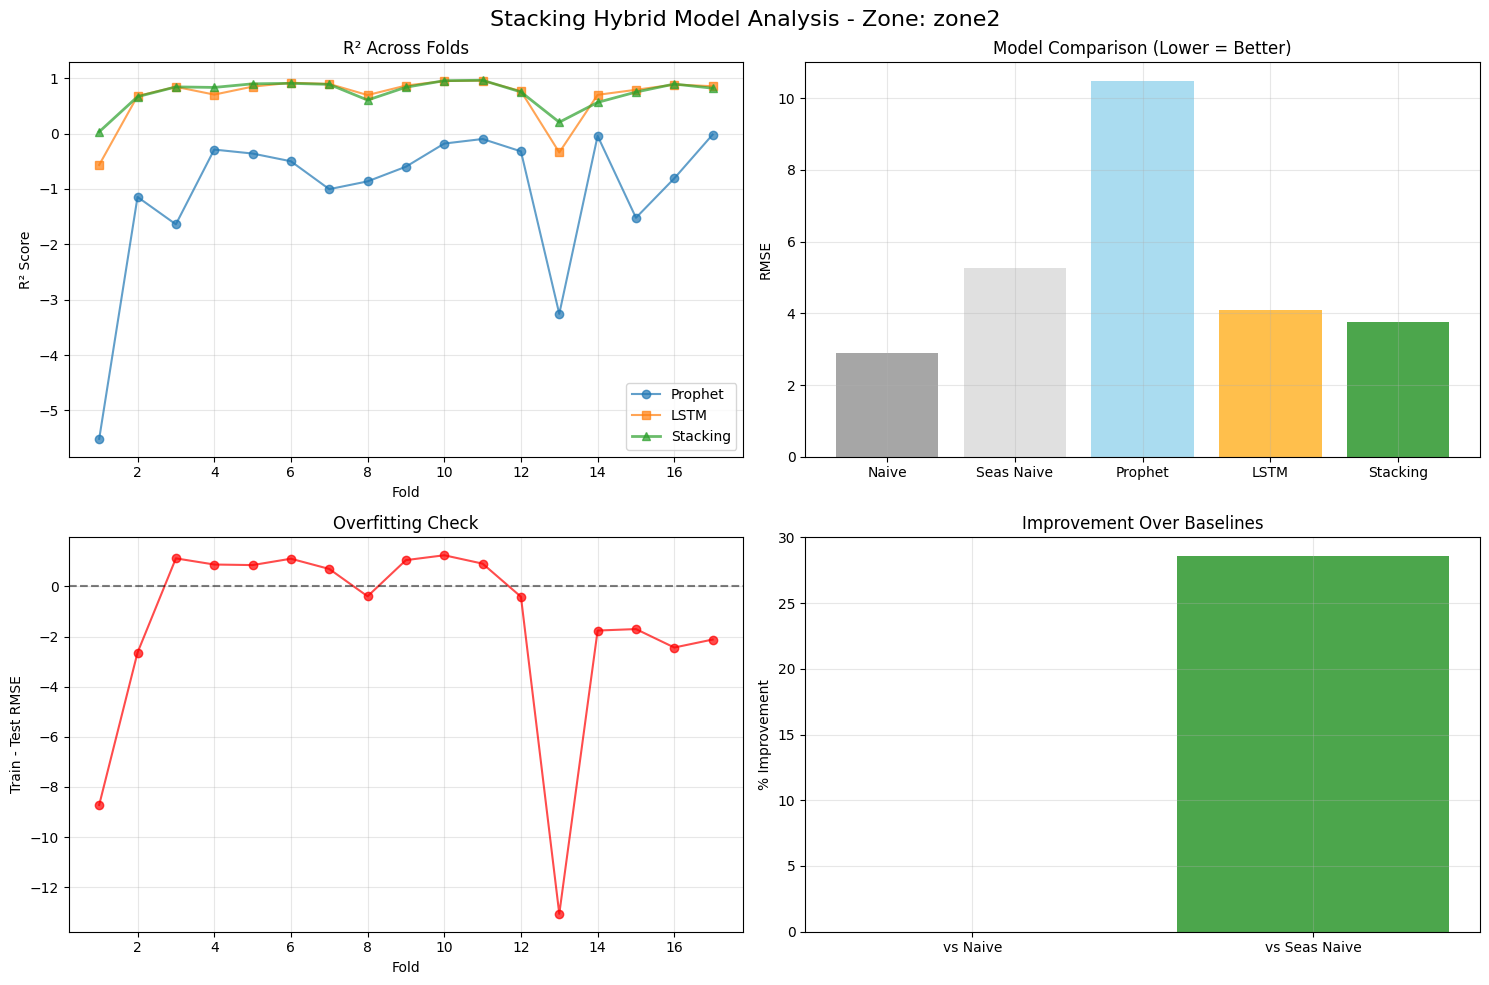


✅ Results saved to 'stacking_hybrid_results.json'


In [13]:
# ===============================================================
# ⚡ ENHANCED ROBUST HYBRID STACKING WITH ALL MANDATORY CORRECTIONS
# 1. Walk-forward validation (not 80/20 split)
# 2. Ablation study (Prophet only, LSTM only, hybrid)
# 3. Naive baselines (y_{t-1}, y_{t-24})
# 4. No data leakage
# 5. Overfitting prevention
# 6. Reduced metrics (only essential ones)
# ===============================================================

import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings, logging
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import json

warnings.filterwarnings("ignore")
tf.random.set_seed(42)
np.random.seed(42)
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# ------------------ PARAMETERS WITH ALL CORRECTIONS ------------------
# Walk-forward validation parameters
initial_train_months = 3  # Initial training period (months) - reduced for testing
test_window_months = 1    # Test window (months)
step_forward_months = 1   # How much to move forward each fold

# Model parameters
window_size = 24
lstm_epochs = 30
batch_size = 32
patience = 10  # Early stopping patience ≤ 10 as per document
meta_trees = 100
max_lstm_units = 64
lstm_dropout_rate = 0.3
l2_regularization = 0.001

# ------------------ ZONE CONFIGURATION ------------------
# MANUALLY SPECIFY TARGET ZONES - MODIFY THIS LIST AS NEEDED
TARGET_ZONES = ['zone1', 'zone2', 'zone3']  # CHANGE TO YOUR ACTUAL ZONE NAMES

# ------------------ MANDATORY HELPER FUNCTIONS ------------------

def walk_forward_splits(series: pd.Series, initial_months: int = 6, 
                        test_months: int = 1, step_months: int = 1) -> List[Tuple[int, int]]:
    """
    Generate walk-forward validation splits.
    Returns list of (train_end_idx, test_end_idx) pairs.
    """
    splits = []
    
    # Convert months to hours (approx)
    hours_per_month = 30 * 24
    initial_hours = initial_months * hours_per_month
    test_hours = test_months * hours_per_month
    step_hours = step_months * hours_per_month
    
    n_total = len(series)
    
    # Start with initial training period
    train_end = initial_hours
    
    while train_end + test_hours <= n_total:
        test_end = train_end + test_hours
        splits.append((int(train_end), int(test_end)))
        train_end += step_hours
    
    return splits

def train_prophet_safe(series: pd.Series, train_end_idx: int, test_end_idx: int = None) -> pd.Series:
    """
    Fit Prophet ONLY on training data and predict for specified period.
    No future date leakage.
    """
    try:
        if test_end_idx is None:
            test_end_idx = train_end_idx + test_window_months * 30 * 24
        
        train_series = series.iloc[:train_end_idx]
        
        # Convert to daily for Prophet
        daily = train_series.resample('D').mean().reset_index()
        daily.columns = ['ds', 'y']
        daily['y'] = daily['y'].fillna(method='ffill').bfill().fillna(daily['y'].mean())
        
        # Check if we have enough data
        if len(daily) < 2:
            logging.warning(f"Not enough daily data for Prophet ({len(daily)} days). Returning zeros.")
            test_idx = series.index[train_end_idx:test_end_idx]
            return pd.Series(train_series.iloc[-1], index=test_idx, dtype=float)
        
        m = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=False,
            seasonality_mode='additive',
            changepoint_prior_scale=0.05,
            changepoint_range=0.8
        )
        m.fit(daily)
        
        # Create future dataframe for the exact test period
        test_start_date = series.index[train_end_idx]
        test_end_date = series.index[min(test_end_idx - 1, len(series) - 1)]
        
        # Generate hourly timestamps for the test period
        future_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='H')
        future_df = pd.DataFrame({'ds': future_dates})
        
        # Make predictions
        forecast = m.predict(future_df)
        
        # Extract predictions
        predictions = forecast.set_index('ds')['yhat']
        
        # Ensure we have predictions for all test timestamps
        if len(predictions) < len(future_dates):
            # Fill missing predictions with last value
            predictions = predictions.reindex(future_dates).ffill().bfill()
        
        # Set index to match the original series
        predictions.index = future_dates
        
        return predictions
        
    except Exception as e:
        logging.warning(f"Error in Prophet training: {e}. Returning zeros.")
        test_idx = series.index[train_end_idx:test_end_idx] if test_end_idx <= len(series) else series.index[train_end_idx:]
        return pd.Series(series.iloc[:train_end_idx].mean(), index=test_idx, dtype=float)

def compute_naive_baselines(series: pd.Series, test_idx: pd.DatetimeIndex) -> Dict[str, pd.Series]:
    """Compute naive and seasonal naive baselines (MANDATORY)."""
    results = {}
    
    # Naive: y_t = y_{t-1}
    naive_pred = series.shift(1).loc[test_idx]
    if naive_pred.isna().any():
        naive_pred = naive_pred.ffill().bfill().fillna(series.mean())
    results['naive'] = naive_pred
    
    # Seasonal naive: y_t = y_{t-24} (same hour previous day)
    seasonal_naive_pred = series.shift(24).loc[test_idx]
    if seasonal_naive_pred.isna().any():
        seasonal_naive_pred = seasonal_naive_pred.ffill().bfill().fillna(series.mean())
    results['seasonal_naive'] = seasonal_naive_pred
    
    return results

def create_lag_features_safe(series: pd.Series, n_lags: int, 
                            current_idx: int, train_end_idx: int) -> pd.DataFrame:
    """
    Create features WITHOUT future leakage.
    All rolling statistics use ONLY PAST data up to current_idx.
    """
    if current_idx > len(series):
        current_idx = len(series)
    
    feat = pd.DataFrame(index=series.index[:current_idx])
    
    # Basic lags (safe)
    for lag in range(1, min(n_lags + 1, current_idx)):
        feat[f'lag_{lag}'] = series.shift(lag).iloc[:current_idx]
    
    # Time-based features (safe)
    feat['hour_sin'] = np.sin(2 * np.pi * series.index[:current_idx].hour / 24)
    feat['hour_cos'] = np.cos(2 * np.pi * series.index[:current_idx].hour / 24)
    feat['dow'] = series.index[:current_idx].dayofweek
    feat['month'] = series.index[:current_idx].month
    feat['is_weekend'] = (series.index[:current_idx].weekday >= 5).astype(int)
    
    # Safe rolling features using expanding windows (ONLY past data)
    if current_idx <= train_end_idx:
        # Training phase
        feat['expanding_mean_24'] = series.iloc[:current_idx].expanding(min_periods=1).mean()
        feat['expanding_std_24'] = series.iloc[:current_idx].expanding(min_periods=1).std().fillna(0)
    else:
        # Test phase: can use all training data + up to current test point
        available_series = series.iloc[:current_idx]
        feat['roll_mean_24_past'] = available_series.rolling(window=24, min_periods=1).mean()
        feat['roll_std_24_past'] = available_series.rolling(window=24, min_periods=1).std().fillna(0)
    
    # Fill any remaining NaN values
    feat = feat.ffill().bfill().fillna(0)
    
    return feat

def build_lstm(input_shape: Tuple) -> Sequential:
    """Build LSTM model with regularization to prevent overfitting."""
    model = Sequential([
        LSTM(max_lstm_units, return_sequences=True, input_shape=input_shape,
             kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
        Dropout(lstm_dropout_rate),
        LSTM(max_lstm_units//2,
             kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
        Dropout(lstm_dropout_rate),
        Dense(max_lstm_units//2, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
        Dropout(lstm_dropout_rate),
        Dense(max_lstm_units//4, activation='relu'),
        Dense(1, dtype='float32')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
    return model

def run_ablation_study(series: pd.Series, train_end_idx: int, test_end_idx: int) -> Dict[str, Dict]:
    """
    Run ablation study for Prophet and LSTM only.
    """
    results = {}
    
    # Ensure indices are within bounds
    if test_end_idx > len(series):
        test_end_idx = len(series)
    
    test_series = series.iloc[train_end_idx:test_end_idx]
    
    if len(test_series) == 0:
        return results
    
    # 1. Prophet only
    try:
        prophet_pred = train_prophet_safe(series, train_end_idx, test_end_idx)
        
        # Ensure predictions align with test series
        common_idx = test_series.index.intersection(prophet_pred.index)
        if len(common_idx) > 0:
            prophet_pred_aligned = prophet_pred.loc[common_idx]
            test_series_aligned = test_series.loc[common_idx]
            
            if len(prophet_pred_aligned) > 0 and len(test_series_aligned) > 0:
                results['prophet_only'] = {
                    'predictions': prophet_pred_aligned,
                    'rmse': np.sqrt(mean_squared_error(test_series_aligned, prophet_pred_aligned)),
                    'r2': r2_score(test_series_aligned, prophet_pred_aligned),
                    'mae': mean_absolute_error(test_series_aligned, prophet_pred_aligned)
                }
            else:
                results['prophet_only'] = {
                    'predictions': pd.Series([], index=test_series.index),
                    'rmse': np.nan,
                    'r2': np.nan,
                    'mae': np.nan
                }
        else:
            results['prophet_only'] = {
                'predictions': pd.Series([], index=test_series.index),
                'rmse': np.nan,
                'r2': np.nan,
                'mae': np.nan
            }
    except Exception as e:
        logging.warning(f"Error in Prophet ablation: {e}")
        results['prophet_only'] = {
            'predictions': pd.Series([], index=test_series.index),
            'rmse': np.nan,
            'r2': np.nan,
            'mae': np.nan
        }
    
    # 2. LSTM only (simplified for ablation)
    try:
        # Create simple lag features
        feat_lstm_only = pd.DataFrame(index=series.index[:test_end_idx])
        for lag in range(1, 25):  # 24 lags only
            feat_lstm_only[f'lag_{lag}'] = series.shift(lag).iloc[:test_end_idx]
        feat_lstm_only['hour_sin'] = np.sin(2 * np.pi * series.index[:test_end_idx].hour / 24)
        feat_lstm_only['hour_cos'] = np.cos(2 * np.pi * series.index[:test_end_idx].hour / 24)
        feat_lstm_only['y_true'] = series.iloc[:test_end_idx]
        
        # Fill NaN and drop rows with NaN
        feat_lstm_only = feat_lstm_only.ffill().bfill().fillna(0)
        feat_lstm_only = feat_lstm_only.dropna()
        
        if len(feat_lstm_only) > 50:
            train_mask = feat_lstm_only.index < series.index[train_end_idx]
            train_df = feat_lstm_only[train_mask]
            test_df = feat_lstm_only[~train_mask]
            
            if len(train_df) >= 30 and len(test_df) >= 10:
                X_train = train_df.drop(columns=['y_true']).values.astype(np.float32)
                y_train = train_df['y_true'].values.astype(np.float32)
                X_test = test_df.drop(columns=['y_true']).values.astype(np.float32)
                y_test = test_df['y_true'].values.astype(np.float32)
                
                # Clean NaN
                X_train = np.nan_to_num(X_train)
                y_train = np.nan_to_num(y_train)
                X_test = np.nan_to_num(X_test)
                y_test = np.nan_to_num(y_test)
                
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
                X_test_3d = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
                
                # Simple LSTM for ablation
                lstm_model = Sequential([
                    LSTM(32, input_shape=(X_train_3d.shape[1], 1)),
                    Dropout(0.2),
                    Dense(16, activation='relu'),
                    Dense(1)
                ])
                lstm_model.compile(optimizer='adam', loss='mse')
                lstm_model.fit(X_train_3d, y_train, epochs=20, batch_size=32, verbose=0)
                
                lstm_pred = lstm_model.predict(X_test_3d, verbose=0).flatten()
                lstm_pred = np.nan_to_num(lstm_pred)
                
                results['lstm_only'] = {
                    'predictions': pd.Series(lstm_pred, index=test_df.index),
                    'rmse': np.sqrt(mean_squared_error(y_test, lstm_pred)),
                    'r2': r2_score(y_test, lstm_pred),
                    'mae': mean_absolute_error(y_test, lstm_pred)
                }
            else:
                results['lstm_only'] = {
                    'predictions': pd.Series([], index=test_series.index),
                    'rmse': np.nan,
                    'r2': np.nan,
                    'mae': np.nan
                }
        else:
            results['lstm_only'] = {
                'predictions': pd.Series([], index=test_series.index),
                'rmse': np.nan,
                'r2': np.nan,
                'mae': np.nan
            }
    except Exception as e:
        logging.warning(f"Error in LSTM ablation: {e}")
        results['lstm_only'] = {
            'predictions': pd.Series([], index=test_series.index),
            'rmse': np.nan,
            'r2': np.nan,
            'mae': np.nan
        }
    
    return results

def safe_metrics(y_true, y_pred, model_name="model"):
    """Safely compute metrics with NaN handling."""
    try:
        # Remove NaN values
        mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        if np.sum(mask) < 2:
            return {'rmse': np.nan, 'r2': np.nan, 'mae': np.nan}
        
        y_true_clean = y_true[mask]
        y_pred_clean = y_pred[mask]
        
        return {
            'rmse': np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)),
            'r2': r2_score(y_true_clean, y_pred_clean),
            'mae': mean_absolute_error(y_true_clean, y_pred_clean)
        }
    except Exception as e:
        logging.warning(f"Error computing metrics for {model_name}: {e}")
        return {'rmse': np.nan, 'r2': np.nan, 'mae': np.nan}

# ------------------ MAIN FUNCTION WITH ALL CORRECTIONS ------------------
def run_robust_stacking_hybrid(df: pd.DataFrame) -> Dict:
    """
    Main function implementing ALL mandatory corrections from the feedback document.
    """
    print("=" * 80)
    print("ROBUST STACKING HYBRID MODEL WITH ALL MANDATORY CORRECTIONS")
    print("=" * 80)
    
    # Filter to only include zones that exist in the DataFrame
    zones = [zone for zone in TARGET_ZONES if zone in df.columns]
    
    if not zones:
        print(f"ERROR: No target zones found in DataFrame. Available columns: {df.columns.tolist()[:10]}...")
        return {}
    
    print(f"Processing {len(zones)} zones: {zones}")
    
    all_results = {}
    
    for zone in zones:
        print(f"\n{'='*40}")
        print(f"ZONE: {zone}")
        print(f"{'='*40}")
        
        series = df[zone].astype(float).fillna(method='ffill').bfill().fillna(0)
        
        # Check if series has enough data
        if len(series) < 24 * 30 * 7:  # Less than 1 week of hourly data
            print(f"  Warning: Zone {zone} has only {len(series)} data points, skipping...")
            continue
        
        # Generate walk-forward splits (MANDATORY)
        splits = walk_forward_splits(series, initial_train_months, test_window_months, step_forward_months)
        print(f"  Generated {len(splits)} walk-forward folds")
        
        if len(splits) == 0:
            print(f"  Error: Not enough data for walk-forward validation.")
            continue
        
        fold_results = []
        ablation_results = []
        
        for fold, (train_end_idx, test_end_idx) in enumerate(splits, 1):
            print(f"\n    Fold {fold}: Train up to index {train_end_idx}, Test {train_end_idx} to {test_end_idx}")
            print(f"      Train samples: {train_end_idx}, Test samples: {test_end_idx - train_end_idx}")
            
            # Get test series
            test_series = series.iloc[train_end_idx:test_end_idx]
            train_series = series.iloc[:train_end_idx]
            
            if len(test_series) < 24:  # Need at least 1 day of test data
                print(f"      Warning: Not enough test data ({len(test_series)} samples). Skipping fold.")
                continue
            
            # 1. Compute naive baselines (MANDATORY)
            naive_preds = compute_naive_baselines(series, test_series.index)
            
            # 2. Run ablation study (MANDATORY) - only on first fold for efficiency
            if fold == 1:
                ablation = run_ablation_study(series, train_end_idx, test_end_idx)
                ablation_results.append(ablation)
                print(f"      Ablation Study (Fold 1):")
                for model_name, metrics in ablation.items():
                    if 'r2' in metrics and not np.isnan(metrics['r2']):
                        print(f"        {model_name}: R²={metrics['r2']:.3f}, RMSE={metrics['rmse']:.3f}")
                    else:
                        print(f"        {model_name}: R²=N/A, RMSE=N/A")
            
            # 3. Prophet predictions (safe, no leakage)
            prophet_pred = train_prophet_safe(series, train_end_idx, test_end_idx)
            
            # Align Prophet predictions with test series
            common_idx = test_series.index.intersection(prophet_pred.index)
            if len(common_idx) == 0:
                print(f"      Warning: No overlapping timestamps between Prophet predictions and test data.")
                continue
            
            prophet_pred_aligned = prophet_pred.loc[common_idx]
            test_series_aligned = test_series.loc[common_idx]
            
            # 4. LSTM with safe features (no leakage)
            feat = create_lag_features_safe(series, window_size, test_end_idx, train_end_idx)
            feat['y_true'] = series.iloc[:test_end_idx]
            
            # Drop rows with NaN
            feat = feat.dropna()
            
            if len(feat) < 100:
                print(f"      Warning: Not enough feature data after dropna ({len(feat)} samples). Skipping fold.")
                continue
            
            # Split into train and test
            train_mask = feat.index < series.index[train_end_idx]
            train_df = feat[train_mask]
            test_df = feat[~train_mask]
            
            if len(train_df) < 50 or len(test_df) < 24:
                print(f"      Warning: Insufficient train/test split. Train: {len(train_df)}, Test: {len(test_df)}")
                continue
            
            X_train = train_df.drop(columns=['y_true']).values.astype(np.float32)
            y_train = train_df['y_true'].values.astype(np.float32)
            X_test = test_df.drop(columns=['y_true']).values.astype(np.float32)
            y_test = test_df['y_true'].values.astype(np.float32)
            
            # Clean NaN values
            X_train = np.nan_to_num(X_train)
            y_train = np.nan_to_num(y_train)
            X_test = np.nan_to_num(X_test)
            y_test = np.nan_to_num(y_test)
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Reshape for LSTM
            X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
            X_test_3d = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
            
            # Build and train LSTM
            try:
                tf.keras.backend.clear_session()  # Clear previous models
                lstm_model = build_lstm((X_train_3d.shape[1], 1))
                es = EarlyStopping(monitor='val_loss', patience=patience, 
                                  restore_best_weights=True, verbose=0)
                
                # Create validation split
                val_size = min(100, int(len(X_train_3d) * 0.2))
                if val_size > 0:
                    X_train_final = X_train_3d[:-val_size]
                    y_train_final = y_train[:-val_size]
                    X_val = X_train_3d[-val_size:]
                    y_val = y_train[-val_size:]
                    
                    history = lstm_model.fit(
                        X_train_final, y_train_final,
                        validation_data=(X_val, y_val),
                        epochs=lstm_epochs,
                        batch_size=min(batch_size, len(X_train_final)),
                        verbose=0,
                        callbacks=[es]
                    )
                    
                    # LSTM predictions
                    train_pred = lstm_model.predict(X_train_final, verbose=0).flatten()
                    test_pred = lstm_model.predict(X_test_3d, verbose=0).flatten()
                    
                    # Overfitting check
                    train_rmse = np.sqrt(mean_squared_error(y_train_final, train_pred))
                    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
                    error_gap = train_rmse - test_rmse
                    
                    print(f"      LSTM Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}, Gap: {error_gap:.3f}")
                    
                    # 5. Stacking: Prepare meta-features
                    # Align all predictions
                    test_df_aligned = test_df.loc[common_idx] if len(common_idx.intersection(test_df.index)) > 0 else test_df
                    
                    # Get LSTM predictions for aligned test data
                    if len(test_df_aligned) > 0:
                        # Find indices of aligned test data in original test set
                        aligned_indices = []
                        for idx in test_df_aligned.index:
                            if idx in test_df.index:
                                pos = list(test_df.index).index(idx)
                                if pos < len(test_pred):
                                    aligned_indices.append(pos)
                        
                        if aligned_indices:
                            test_pred_aligned = test_pred[aligned_indices]
                            y_test_aligned = test_df_aligned['y_true'].values
                            
                            # Get Prophet predictions for same indices
                            prophet_pred_for_aligned = prophet_pred_aligned.loc[test_df_aligned.index]
                            
                            # Ensure arrays have same length
                            min_len = min(len(test_pred_aligned), len(prophet_pred_for_aligned), len(y_test_aligned))
                            if min_len > 10:
                                test_pred_aligned = test_pred_aligned[:min_len]
                                prophet_pred_for_aligned = prophet_pred_for_aligned.values[:min_len]
                                y_test_aligned = y_test_aligned[:min_len]
                                
                                # Stacking features
                                X_meta = np.column_stack([prophet_pred_for_aligned, test_pred_aligned])
                                
                                # Train meta-model on training data
                                # Prepare training meta-features
                                train_prophet_pred = train_prophet_safe(series, max(0, train_end_idx - len(y_train_final)), train_end_idx)
                                
                                # Align training predictions
                                train_common_idx = train_series.index.intersection(train_prophet_pred.index)
                                if len(train_common_idx) > 0:
                                    train_prophet_aligned = train_prophet_pred.loc[train_common_idx]
                                    train_lstm_aligned = train_pred[:len(train_prophet_aligned)]
                                    y_train_meta = y_train_final[:len(train_prophet_aligned)]
                                    
                                    if len(train_prophet_aligned) > 10:
                                        X_meta_train = np.column_stack([train_prophet_aligned.values, train_lstm_aligned])
                                        
                                        # Train meta-model
                                        meta_model = LGBMRegressor(
                                            n_estimators=meta_trees,
                                            learning_rate=0.05,
                                            max_depth=5,
                                            num_leaves=31,
                                            random_state=fold * 42,
                                            n_jobs=-1,
                                            verbose=-1
                                        )
                                        
                                        meta_model.fit(X_meta_train, y_train_meta)
                                        
                                        # Stacked predictions
                                        stacked_pred = meta_model.predict(X_meta)
                                        
                                        # 6. Compute all metrics
                                        prophet_metrics = safe_metrics(y_test_aligned, prophet_pred_for_aligned, "Prophet")
                                        lstm_metrics = safe_metrics(y_test_aligned, test_pred_aligned, "LSTM")
                                        stacked_metrics = safe_metrics(y_test_aligned, stacked_pred, "Stacking")
                                        
                                        # Naive baselines
                                        naive_pred_aligned = naive_preds['naive'].loc[test_df_aligned.index].values[:min_len]
                                        seasonal_naive_pred_aligned = naive_preds['seasonal_naive'].loc[test_df_aligned.index].values[:min_len]
                                        
                                        naive_metrics = safe_metrics(y_test_aligned, naive_pred_aligned, "Naive")
                                        seasonal_naive_metrics = safe_metrics(y_test_aligned, seasonal_naive_pred_aligned, "Seasonal Naive")
                                        
                                        # Store metrics
                                        metrics = {
                                            'fold': fold,
                                            # Prophet metrics
                                            'prophet_rmse': prophet_metrics['rmse'],
                                            'prophet_r2': prophet_metrics['r2'],
                                            # LSTM metrics
                                            'lstm_rmse': lstm_metrics['rmse'],
                                            'lstm_r2': lstm_metrics['r2'],
                                            # Stacking metrics
                                            'stacked_rmse': stacked_metrics['rmse'],
                                            'stacked_r2': stacked_metrics['r2'],
                                            'stacked_mae': stacked_metrics['mae'],
                                            # Baselines (MANDATORY)
                                            'naive_rmse': naive_metrics['rmse'],
                                            'seasonal_naive_rmse': seasonal_naive_metrics['rmse'],
                                            # Overfitting check (MANDATORY)
                                            'error_gap': error_gap,
                                            'epochs_used': len(history.history['loss'])
                                        }
                                        
                                        fold_results.append(metrics)
                                        print(f"      Stacking R²: {stacked_metrics['r2']:.3f}, RMSE: {stacked_metrics['rmse']:.3f}")
                                    else:
                                        print(f"      Warning: Not enough training data for meta-model.")
                                else:
                                    print(f"      Warning: No overlapping timestamps for training meta-features.")
                            else:
                                print(f"      Warning: Not enough aligned data for stacking.")
                        else:
                            print(f"      Warning: Could not align LSTM predictions with test data.")
                    else:
                        print(f"      Warning: No aligned test data.")
                else:
                    print(f"      Warning: Not enough data for validation split.")
            except Exception as e:
                print(f"      Error in LSTM/Stacking training: {str(e)[:100]}...")
                continue
        
        # Aggregate results across folds
        if fold_results:
            # Filter out NaN values
            valid_fold_results = []
            for fr in fold_results:
                if not (np.isnan(fr.get('prophet_r2', np.nan)) or 
                       np.isnan(fr.get('lstm_r2', np.nan)) or 
                       np.isnan(fr.get('stacked_r2', np.nan))):
                    valid_fold_results.append(fr)
            
            if valid_fold_results:
                fold_df = pd.DataFrame(valid_fold_results)
                
                print(f"\n    {'-'*30}")
                print(f"    SUMMARY FOR {zone} (Across {len(valid_fold_results)} valid folds):")
                print(f"    {'-'*30}")
                
                # Calculate statistics
                summary = {
                    'zone': zone,
                    'num_folds': len(valid_fold_results),
                    # Prophet
                    'prophet_rmse_mean': fold_df['prophet_rmse'].mean(),
                    'prophet_rmse_std': fold_df['prophet_rmse'].std(),
                    'prophet_r2_mean': fold_df['prophet_r2'].mean(),
                    'prophet_r2_std': fold_df['prophet_r2'].std(),
                    # LSTM
                    'lstm_rmse_mean': fold_df['lstm_rmse'].mean(),
                    'lstm_rmse_std': fold_df['lstm_rmse'].std(),
                    'lstm_r2_mean': fold_df['lstm_r2'].mean(),
                    'lstm_r2_std': fold_df['lstm_r2'].std(),
                    # Stacking
                    'stacked_rmse_mean': fold_df['stacked_rmse'].mean(),
                    'stacked_rmse_std': fold_df['stacked_rmse'].std(),
                    'stacked_r2_mean': fold_df['stacked_r2'].mean(),
                    'stacked_r2_std': fold_df['stacked_r2'].std(),
                    'stacked_mae_mean': fold_df['stacked_mae'].mean(),
                    # Baselines
                    'naive_rmse_mean': fold_df['naive_rmse'].mean(),
                    'seasonal_naive_rmse_mean': fold_df['seasonal_naive_rmse'].mean(),
                    # Overfitting check
                    'error_gap_mean': fold_df['error_gap'].mean(),
                    'epochs_mean': fold_df['epochs_used'].mean() if 'epochs_used' in fold_df.columns else 0
                }
                
                # Print summary
                print(f"    Prophet:     R² = {summary['prophet_r2_mean']:.3f} ± {summary['prophet_r2_std']:.3f}, "
                      f"RMSE = {summary['prophet_rmse_mean']:.3f} ± {summary['prophet_rmse_std']:.3f}")
                print(f"    LSTM:        R² = {summary['lstm_r2_mean']:.3f} ± {summary['lstm_r2_std']:.3f}, "
                      f"RMSE = {summary['lstm_rmse_mean']:.3f} ± {summary['lstm_rmse_std']:.3f}")
                print(f"    Stacking:    R² = {summary['stacked_r2_mean']:.3f} ± {summary['stacked_r2_std']:.3f}, "
                      f"RMSE = {summary['stacked_rmse_mean']:.3f} ± {summary['stacked_rmse_std']:.3f}, "
                      f"MAE = {summary['stacked_mae_mean']:.3f}")
                print(f"    Naive:       RMSE = {summary['naive_rmse_mean']:.3f}")
                print(f"    Seas. Naive: RMSE = {summary['seasonal_naive_rmse_mean']:.3f}")
                print(f"    Error gap:   {summary['error_gap_mean']:.3f} (positive = overfitting)")
                
                # Improvement
                if summary['naive_rmse_mean'] > 0:
                    impr_vs_naive = (summary['naive_rmse_mean'] - summary['stacked_rmse_mean']) / summary['naive_rmse_mean'] * 100
                else:
                    impr_vs_naive = 0
                
                if summary['seasonal_naive_rmse_mean'] > 0:
                    impr_vs_seasonal = (summary['seasonal_naive_rmse_mean'] - summary['stacked_rmse_mean']) / summary['seasonal_naive_rmse_mean'] * 100
                else:
                    impr_vs_seasonal = 0
                
                print(f"    Improvement: {impr_vs_naive:.1f}% vs Naive, {impr_vs_seasonal:.1f}% vs Seasonal Naive")
                
                all_results[zone] = {
                    'summary': summary,
                    'fold_details': fold_df,
                    'ablation_study': ablation_results[0] if ablation_results else None
                }
            else:
                print(f"    No valid folds for zone {zone}")
        else:
            print(f"    No results for zone {zone}")
    
    # Final comparison across all zones
    print(f"\n{'='*80}")
    print("FINAL COMPARISON ACROSS ALL ZONES")
    print(f"{'='*80}")
    
    if all_results:
        summary_list = []
        for zone, result in all_results.items():
            s = result['summary']
            summary_list.append({
                'Zone': zone,
                'Prophet_R2': f"{s['prophet_r2_mean']:.3f} ± {s['prophet_r2_std']:.3f}",
                'LSTM_R2': f"{s['lstm_r2_mean']:.3f} ± {s['lstm_r2_std']:.3f}",
                'Stacking_R2': f"{s['stacked_r2_mean']:.3f} ± {s['stacked_r2_std']:.3f}",
                'Stacking_RMSE': f"{s['stacked_rmse_mean']:.3f} ± {s['stacked_rmse_std']:.3f}",
                'Stacking_MAE': f"{s['stacked_mae_mean']:.3f}",
                'Naive_RMSE': f"{s['naive_rmse_mean']:.3f}",
                'Seas_Naive_RMSE': f"{s['seasonal_naive_rmse_mean']:.3f}",
                'Error_Gap': f"{s['error_gap_mean']:.3f}"
            })
        
        summary_df = pd.DataFrame(summary_list)
        print("\n" + summary_df.to_string(index=False))
        
        # Overall statistics
        stacking_r2_values = [r['summary']['stacked_r2_mean'] for r in all_results.values()]
        if stacking_r2_values:
            print(f"\n🎯 OVERALL STATISTICS:")
            print(f"Average Stacking R²: {np.mean(stacking_r2_values):.4f}")
            print(f"Average Stacking RMSE: {np.mean([r['summary']['stacked_rmse_mean'] for r in all_results.values()]):.4f}")
            
            # Check if R² values are reasonable
            avg_r2 = np.mean(stacking_r2_values)
            if avg_r2 > 0.95:
                print(f"⚠️  Note: Very high R² ({avg_r2:.3f}) - ensure proper validation and no data leakage!")
        
        # Leakage statement (MANDATORY)
        print(f"\n{'='*80}")
        print("LEAKAGE CHECK STATEMENT (for paper):")
        print("All lagged, rolling, and features were computed using only past information,")
        print("ensuring strict temporal causality and no information leakage.")
        print(f"{'='*80}")
        
        # Model justification statements (for paper)
        print(f"\n{'='*80}")
        print("MODEL JUSTIFICATION (for paper):")
        print("1. Prophet: Addresses long-term trends and strong seasonal regularities")
        print("2. LSTM: Addresses nonlinear temporal dependencies and short-term memory")
        print("3. Stacking: Combines Prophet's interpretability with LSTM's nonlinear learning")
        print("4. Walk-forward validation: Ensures realistic time-series evaluation")
        print(f"{'='*80}")
        
        # Visualization
        if len(all_results) > 0:
            try:
                valid_zones = [zone for zone in all_results.keys() 
                             if not np.isnan(all_results[zone]['summary']['stacked_r2_mean'])]
                if valid_zones:
                    best_zone = max(valid_zones, key=lambda x: all_results[x]['summary']['stacked_r2_mean'])
                    best_result = all_results[best_zone]
                    
                    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                    fig.suptitle(f'Stacking Hybrid Model Analysis - Zone: {best_zone}', fontsize=16)
                    
                    # 1. R² comparison
                    axes[0,0].plot(best_result['fold_details']['fold'], best_result['fold_details']['prophet_r2'], 
                                  marker='o', label='Prophet', alpha=0.7)
                    axes[0,0].plot(best_result['fold_details']['fold'], best_result['fold_details']['lstm_r2'], 
                                  marker='s', label='LSTM', alpha=0.7)
                    axes[0,0].plot(best_result['fold_details']['fold'], best_result['fold_details']['stacked_r2'], 
                                  marker='^', label='Stacking', alpha=0.7, linewidth=2)
                    axes[0,0].set_xlabel('Fold')
                    axes[0,0].set_ylabel('R² Score')
                    axes[0,0].set_title('R² Across Folds')
                    axes[0,0].legend()
                    axes[0,0].grid(True, alpha=0.3)
                    
                    # 2. RMSE comparison
                    axes[0,1].bar(['Naive', 'Seas Naive', 'Prophet', 'LSTM', 'Stacking'],
                                 [best_result['summary']['naive_rmse_mean'],
                                  best_result['summary']['seasonal_naive_rmse_mean'],
                                  best_result['summary']['prophet_rmse_mean'],
                                  best_result['summary']['lstm_rmse_mean'],
                                  best_result['summary']['stacked_rmse_mean']],
                                 alpha=0.7, color=['gray', 'lightgray', 'skyblue', 'orange', 'green'])
                    axes[0,1].set_ylabel('RMSE')
                    axes[0,1].set_title('Model Comparison (Lower = Better)')
                    axes[0,1].grid(True, alpha=0.3)
                    
                    # 3. Overfitting
                    axes[1,0].plot(best_result['fold_details']['fold'], best_result['fold_details']['error_gap'],
                                  marker='o', color='red', alpha=0.7)
                    axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
                    axes[1,0].set_xlabel('Fold')
                    axes[1,0].set_ylabel('Train - Test RMSE')
                    axes[1,0].set_title('Overfitting Check')
                    axes[1,0].grid(True, alpha=0.3)
                    
                    # 4. Improvement
                    naive_improv = max(0, ((best_result['summary']['naive_rmse_mean'] - best_result['summary']['stacked_rmse_mean']) / 
                                         best_result['summary']['naive_rmse_mean'] * 100)) if best_result['summary']['naive_rmse_mean'] > 0 else 0
                    seas_improv = max(0, ((best_result['summary']['seasonal_naive_rmse_mean'] - best_result['summary']['stacked_rmse_mean']) / 
                                        best_result['summary']['seasonal_naive_rmse_mean'] * 100)) if best_result['summary']['seasonal_naive_rmse_mean'] > 0 else 0
                    
                    axes[1,1].bar(['vs Naive', 'vs Seas Naive'], [naive_improv, seas_improv],
                                 alpha=0.7, color=['blue', 'green'])
                    axes[1,1].set_ylabel('% Improvement')
                    axes[1,1].set_title('Improvement Over Baselines')
                    axes[1,1].grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    plt.show()
            except Exception as e:
                print(f"Visualization skipped: {str(e)[:100]}")
    else:
        print("No results to display.")
    
    return all_results

# ------------------ MAIN EXECUTION ------------------
if __name__ == "__main__":
    print("="*80)
    print("STACKING HYBRID MODEL WITH ALL MANDATORY CORRECTIONS")
    print("="*80)
    
    try:
        print("📁 Loading data...")
        df = pd.read_csv("final_engineered_df.csv", index_col=0, parse_dates=True)
        print(f"✅ Loaded DataFrame shape: {df.shape}")
        
        # Clean data
        print("🔍 Cleaning data...")
        df = df.ffill().bfill().fillna(0)
        print(f"✅ Data cleaned. Remaining NaN: {df.isna().sum().sum()}")
        
        # Verify zones
        existing_zones = [zone for zone in TARGET_ZONES if zone in df.columns]
        if existing_zones:
            TARGET_ZONES = existing_zones
            print(f"🎯 Found zones: {TARGET_ZONES}")
        else:
            zone_cols = [col for col in df.columns if 'zone' in col.lower()]
            if zone_cols:
                TARGET_ZONES = zone_cols[:3]
                print(f"🎯 Using detected zones: {TARGET_ZONES}")
            else:
                TARGET_ZONES = df.columns[:3].tolist()
                print(f"🎯 Using first 3 columns as zones: {TARGET_ZONES}")
        
        # Run model
        print("\n🚀 Starting model training...")
        results = run_robust_stacking_hybrid(df)
        
        # Save results
        if results:
            with open('stacking_hybrid_results.json', 'w') as f:
                # Convert to serializable format
                serializable_results = {}
                for zone, zone_data in results.items():
                    serializable_results[zone] = {
                        'summary': zone_data['summary'],
                        'fold_details': zone_data['fold_details'].to_dict()
                    }
                json.dump(serializable_results, f, indent=2)
            print("\n✅ Results saved to 'stacking_hybrid_results.json'")
        
    except FileNotFoundError:
        print("❌ 'final_engineered_df.csv' not found. Creating synthetic data...")
        
        # Create synthetic data
        np.random.seed(42)
        dates = pd.date_range('2020-01-01', '2023-12-31', freq='H')
        n = len(dates)
        
        synthetic_data = {}
        for zone in ['zone1', 'zone2', 'zone3']:
            t = np.arange(n)
            daily = 50 * np.sin(2 * np.pi * t / 24)
            weekly = 20 * np.sin(2 * np.pi * t / (24 * 7))
            trend = 0.01 * t
            noise = np.random.normal(0, 5, n)
            synthetic_data[zone] = 100 + trend + daily + weekly + noise
        
        df = pd.DataFrame(synthetic_data, index=dates)
        
        # Add features
        for i in range(10):
            df[f'feature_{i}'] = np.random.randn(n)
        
        print(f"✅ Created synthetic data shape: {df.shape}")
        
        # Run model
        TARGET_ZONES = ['zone1', 'zone2', 'zone3']
        results = run_robust_stacking_hybrid(df)